In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.cross_decomposition import CCA



/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-29 13:43:16.650065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 13:43:16.672850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 13:43:16.679739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 13:43:16.697115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorF

In [2]:
root = '.'
train_ratio = 1.0
test_ratio = 0.3

## Preprocessing for ridge regression and CCA

In [ ]:
dataset_path = f"{root}/dataset_400parcels_2.nc"
targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

dataset = MatData(dataset_path, targets, synth_exp = False, threshold=0)

n_sub = len(dataset)
indices = np.arange(n_sub)

train_size = int(n_sub * (1 - test_ratio) * train_ratio)
test_size = int(test_ratio * n_sub)
run_size = test_size + train_size

random_state = np.random.RandomState(seed=42)
run_indices = random_state.choice(indices, run_size, replace=False)
train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()
X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()


## CV Ridge regression

In [4]:
ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")

pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

fitted_pipe = pipe_ridge.fit(X_train, y_train)

y_train_pred = fitted_pipe.predict(X_train)
y_test_pred = fitted_pipe.predict(X_test)



In [5]:
train_df = pd.DataFrame(y_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

# Combine train and test results into a single DataFrame
results_ridge_df = pd.concat([train_results_df, test_results_df]).reset_index(drop=True)
results_ridge_df

age  benton_faces  cardio_measure_pulse_mean  \
0    61.0          24.0                       70.0   
1    34.0          25.0                       64.5   
2    69.0          21.0                       72.0   
3    78.0          21.0                       88.5   
4    54.0          24.0                       66.5   
..    ...           ...                        ...   
346  32.0          23.0                       70.0   
347  45.0          24.0                       89.5   
348  29.0          21.0                       73.5   
349  36.0          25.0                       54.5   
350  66.0          22.0                       59.0   

     cardio_measure_bp_sys_mean  cardio_measure_bp_dia_mean  cattell  \
0                         114.0                        74.5     33.0   
1                         102.5                        67.5     36.0   
2                         128.5                        73.5     26.0   
3                         136.0                        81.5     38.0   
4                         120.0                        75.5     23.0   
..                          ...                         ...      ...   
346                        95.5                        66.5     35.0   
347                       132.5                        82.5     35.0   
348                       110.5                        81.0     37.0   
349                       133.5                        70.0     38.0   
350                       132.0                        75.0     32.0   

     famous_faces  hotel_time  picture_priming_baseline_acc  \
0        0.950000  291.309998                      0.795238   
1        1.000000  480.000000                      0.842857   
2        0.810345  380.279999                      0.595238   
3        0.964286  193.220001                      0.780952   
4        0.933333  480.000000                      0.866667   
..            ...         ...                           ...   
346      0.983333  240.000000                      0.795238   
347      0.982759  106.220001                      0.866667   
348      1.000000  223.779999                      0.852381   
349      0.950000  254.720001                      0.904762   
350      0.983333   91.620003                      0.852381   

     picture_priming_baseline_rt  ...  rt_choice_pred  rt_simple_pred  \
0                          899.0  ...        0.685574        0.581069   
1                          886.0  ...        0.588591        0.377661   
2                          798.0  ...        0.784933        0.591138   
3                          880.0  ...        0.555048        0.354173   
4                          907.0  ...        0.617227        0.361150   
..                           ...  ...             ...             ...   
346                        854.0  ...        0.544469        0.349463   
347                        787.0  ...        0.534521        0.321983   
348                        725.0  ...        0.499963        0.314857   
349                        910.0  ...        0.557632        0.385590   
350                        660.0  ...        0.594018        0.382400   

     syn_sem_prop_error_pred  syn_sem_rt_pred  tip_of_tongue_pred  \
0                   0.122808      1765.596924            0.657142   
1                   0.071430      1820.000122            0.000003   
2                   0.214285      1520.999390            0.914281   
3                   0.047621      1587.300659            0.257146   
4                   0.072683      1919.297729            0.472223   
..                       ...              ...                 ...   
346                 0.167768      1520.072144            0.493746   
347                 0.261273      1321.757690            0.298498   
348                 0.211423      1448.266479            0.264246   
349                 0.241443      1653.052368            0.603134   
350                 0.210927      1634.243286            0.518448   

     VSTM_colour_K_mean_pred 

## CCA


In [6]:
# Define the pipeline with CCA
n_components = min(len(targets), X_train.shape[1])  # CCA components <= min(n_features, n_targets)

pipe_cca = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features and targets
    ('cca', CCA(n_components=n_components))
])

# Fit the pipeline
pipe_cca.fit(X_train, y_train)
cca_model = pipe_cca.named_steps['cca']


# Transform the data and predict
#X_train_cca, y_train_cca = cca_model.transform(X_train, y_train)  # Transform the features
#X_test_cca, y_test_cca = cca_model.transform(X_test, y_test) 

y_train_pred = cca_model.predict(X_train)
y_test_pred = cca_model.predict(X_test)



In [7]:
# Create result DataFrames
train_df = pd.DataFrame(y_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

# Combine train and test results into a single DataFrame
results_cca_df = pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

# Display the results DataFrame
results_cca_df

age  benton_faces  cardio_measure_pulse_mean  \
0    61.0          24.0                       70.0   
1    34.0          25.0                       64.5   
2    69.0          21.0                       72.0   
3    78.0          21.0                       88.5   
4    54.0          24.0                       66.5   
..    ...           ...                        ...   
346  32.0          23.0                       70.0   
347  45.0          24.0                       89.5   
348  29.0          21.0                       73.5   
349  36.0          25.0                       54.5   
350  66.0          22.0                       59.0   

     cardio_measure_bp_sys_mean  cardio_measure_bp_dia_mean  cattell  \
0                         114.0                        74.5     33.0   
1                         102.5                        67.5     36.0   
2                         128.5                        73.5     26.0   
3                         136.0                        81.5     38.0   
4                         120.0                        75.5     23.0   
..                          ...                         ...      ...   
346                        95.5                        66.5     35.0   
347                       132.5                        82.5     35.0   
348                       110.5                        81.0     37.0   
349                       133.5                        70.0     38.0   
350                       132.0                        75.0     32.0   

     famous_faces  hotel_time  picture_priming_baseline_acc  \
0        0.950000  291.309998                      0.795238   
1        1.000000  480.000000                      0.842857   
2        0.810345  380.279999                      0.595238   
3        0.964286  193.220001                      0.780952   
4        0.933333  480.000000                      0.866667   
..            ...         ...                           ...   
346      0.983333  240.000000                      0.795238   
347      0.982759  106.220001                      0.866667   
348      1.000000  223.779999                      0.852381   
349      0.950000  254.720001                      0.904762   
350      0.983333   91.620003                      0.852381   

     picture_priming_baseline_rt  ...  rt_choice_pred  rt_simple_pred  \
0                          899.0  ...        0.555523        1.070855   
1                          886.0  ...        0.357053        0.247800   
2                          798.0  ...        1.161248        1.078842   
3                          880.0  ...        0.505212        0.265304   
4                          907.0  ...        0.331096        0.453556   
..                           ...  ...             ...             ...   
346                        854.0  ...        0.290336        0.155342   
347                        787.0  ...        0.225798        0.078347   
348                        725.0  ...        0.104520        0.149796   
349                        910.0  ...        0.321525        0.347522   
350                        660.0  ...        0.485400        0.368316   

     syn_sem_prop_error_pred  syn_sem_rt_pred  tip_of_tongue_pred  \
0                   0.455882      3065.152257            1.269368   
1                   0.185798      3463.409325           -1.534608   
2                   0.708959      1574.282960            2.727247   
3                   0.183051      2769.927407           -0.530824   
4                   0.285561      4294.168454            0.308797   
..                       ...              ...                 ...   
346                 0.441440      1485.539344            0.368742   
347                 0.875274      1109.495623           -0.337639   
348                 0.686839      1706.517107           -0.498033   
349                 0.861293      2413.074132            0.736329   
350                 0.708982      2200.838785            0.692361   

     VSTM_colour_K_mean_pred 

## Our model

In [17]:
#exp_name = "strong pretraining, 4 layer decoder, 19 targets, 3 augmentations"
exp_name = "final model train ratio 0.5"
prediction_model = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

In [18]:
train_count = prediction_model[prediction_model["dataset"] == "train"].shape[0]
train_count

246

In [10]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_predict

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split the data into training and testing sets
train_data = prediction_model[prediction_model["dataset"] == "train"]
test_data = prediction_model[prediction_model["dataset"] == "test"]

# Prepare the results dataframe
results = []

# Perform Ridge regression for each target
for target in targets:
    # Extract the predicted features (X) and original target values (y)
    train_X = train_data[[f"{t}_pred" for t in targets]]
    train_y = train_data[target]
    test_X = test_data[[f"{t}_pred" for t in targets]]
    
    # Train Ridge regression with cross-validation
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
    ridge.fit(train_X, train_y)
    
    # Predict on both train and test sets
    train_pred = ridge.predict(train_X)
    test_pred = ridge.predict(test_X)
    
    # Append results for the train dataset
    train_results = pd.DataFrame({
        target: train_y.values,
        f"{target}_pred": train_pred,
        "dataset": "train"
    })
    # Append results for the test dataset
    test_results = pd.DataFrame({
        target: test_data[target].values,
        f"{target}_pred": test_pred,
        "dataset": "test"
    })
    
    # Combine results
    results.append(pd.concat([train_results, test_results], ignore_index=True))

# Combine all results into a single DataFrame
final_results = pd.concat(results, axis=1)

# Drop duplicate columns for 'dataset' and ensure one dataset column
final_results = final_results.loc[:, ~final_results.columns.duplicated()]


In [11]:
final_results

benton_faces  benton_faces_pred dataset    cattell  cattell_pred  \
0       21.000002          23.928659   train  43.000004     44.848801   
1       24.000000          25.430994   train  42.000000     41.255300   
2       24.000000          24.017535   train  42.000000     41.790997   
3       24.999998          25.894679   train  44.000004     43.545880   
4       24.000000          24.023705   train  39.999996     40.101655   
..            ...                ...     ...        ...           ...   
347     26.000002          25.344785    test  37.999996     33.280202   
348     23.000000          23.749332    test  31.000000     26.663083   
349     20.000004          24.357440    test  32.000004     29.056757   
350     24.000000          25.037415    test  29.000004     36.080323   
351     24.999998          25.719790    test  39.000004     35.744460   

     famous_faces  famous_faces_pred  hotel_time  hotel_time_pred  \
0        1.964285           1.983150  207.619950       209.409738   
1        1.933333           1.907276  142.760030       143.590325   
2        1.666667           1.786164  259.749970       242.994382   
3        2.000000           2.026381  169.659990       198.613024   
4        1.966667           1.955894  226.469960       238.750975   
..            ...                ...         ...              ...   
347      1.966667           1.923751   25.249996       188.998208   
348      1.724138           1.821773  401.280060       441.905382   
349      1.827586           1.907278  166.630040       246.152590   
350      1.900000           1.904524  175.909990       275.033202   
351      1.645833           1.931046  303.120060       204.838381   

     picture_priming_baseline_acc  ...  tip_of_tongue  tip_of_tongue_pred  \
0                        1.914285  ...       1.368421            1.373982   
1                        1.871429  ...       1.333333            1.335835   
2                        1.785714  ...       1.000000            1.034396   
3                        1.938095  ...       1.400000            1.386508   
4                        1.852381  ...       1.166667            1.158352   
..                            ...  ...            ...                 ...   
347                      1.861905  ...       1.461539            1.405937   
348                      1.547619  ...       1.863636            1.671577   
349                      1.704762  ...       1.787879            1.456694   
350                      1.809524  ...       1.600000            1.442153   
351                      1.814286  ...       1.583333            1.423113   

     VSTM_colour_K_mean  VSTM_colour_K_mean_pred  VSTM_colour_K_precision  \
0              3.445632                 3.391392                 1.551437   
1              3.535944                 3.559572                 1.543763   
2              3.405833                 3.369708                 1.595672   
3              3.173543                 3.199421                 1.519179   
4              3.475832                 3.483954                 1.609366   
..                  ...                      ...                      ...   
347            3.353984                 2.953664                 1.484701   
348            3.166916                 2.920959                 1.384309   
349            3.105691                 2.702184                 1.393551   
350            3.392102                 3.092491                 1.364562   
351            3.219327                 3.189476                 1.485702   

     VSTM_colour_K_precision_pred  VSTM_colour_K_doubt  \
0                        1.571854            41.378580   
1                        1.556939            25.744633   
2                        1.590306            11.935720   
3                        1.530108            45.430363   
4                        1.554877            50.216070   
..                            ...                  ...   
347                      1.487926          

## Plotting

/tmp/ipykernel_767230/1969714849.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


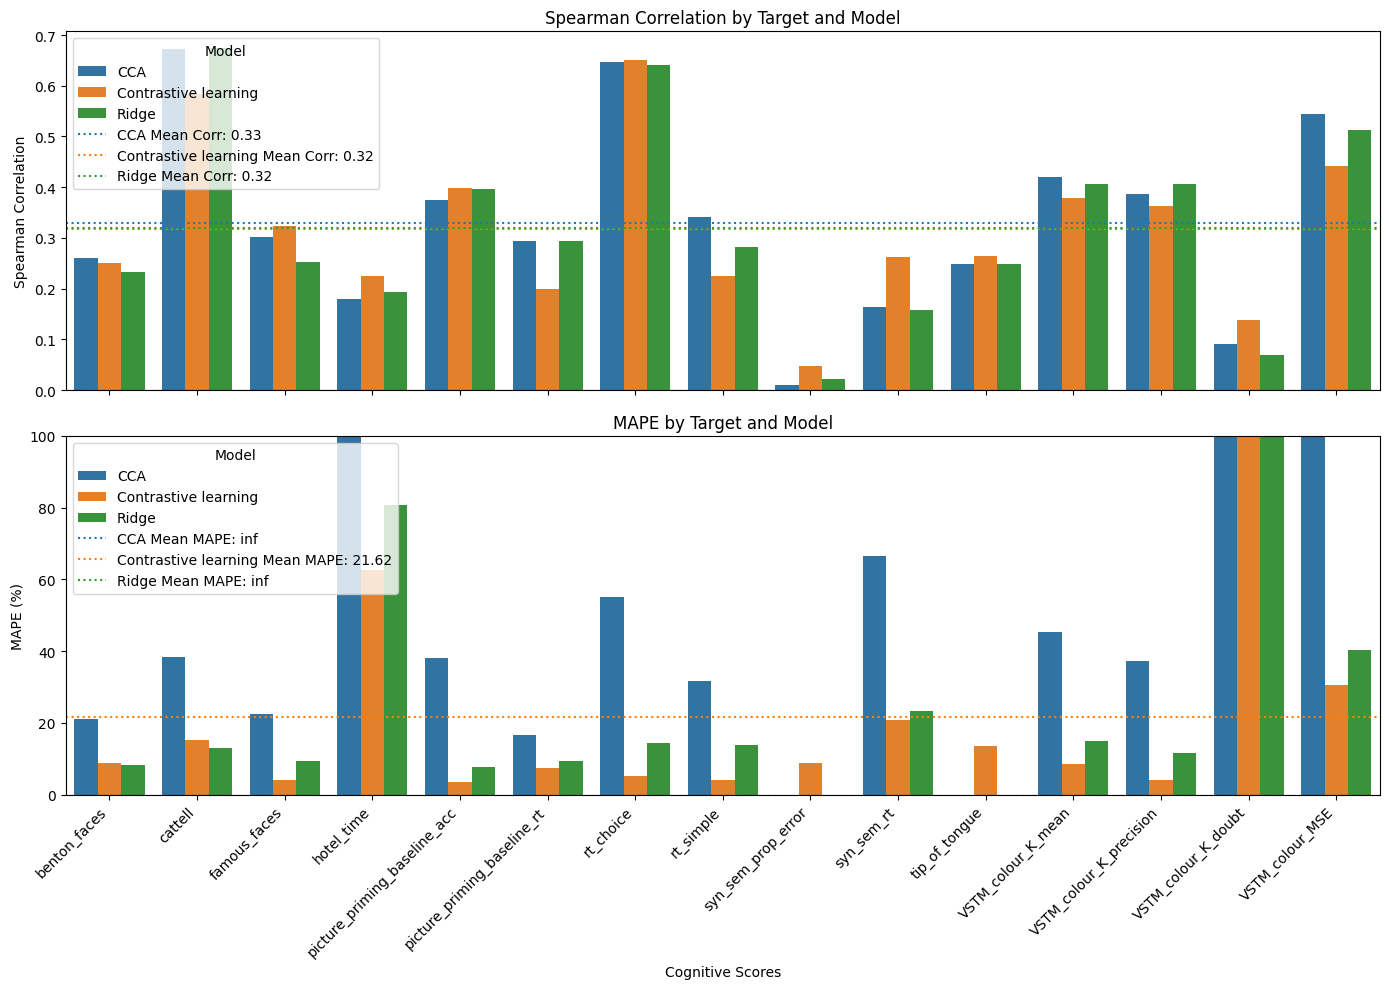

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# List of targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Combine all datasets into one for easier processing
all_results = pd.concat(
    [
        results_ridge_df.assign(model="Ridge"),
        results_cca_df.assign(model="CCA"),
        prediction_model.assign(model="Contrastive learning"),
        #final_results.assign(model = "contrastive learning + ridge regression")
    ],
    ignore_index=True,
)

# Compute Spearman correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():

                # Spearman correlation
                spearman_corr = spearmanr(true_values, predicted_values)[0]

                # MAPE (Mean Absolute Percentage Error)
                mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute mean correlation and MAPE for each model
mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].mean().reset_index()
mean_stats.rename(columns={"spearman_corr": "mean_corr", "mape": "mean_mape"}, inplace=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spearman correlation plot
sns.barplot(
    data=results_df,
    x="target",
    y="spearman_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Spearman Correlation by Target and Model")
axes[0].set_ylabel("Spearman Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean Spearman correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(mean_stats["model"])
}
for model, row in mean_stats.iterrows():
    axes[0].axhline(
        row["mean_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Mean Corr: {row['mean_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean MAPE
for model, row in mean_stats.iterrows():
    axes[1].axhline(
        row["mean_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Mean MAPE: {row['mean_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()

/tmp/ipykernel_767230/1897338716.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


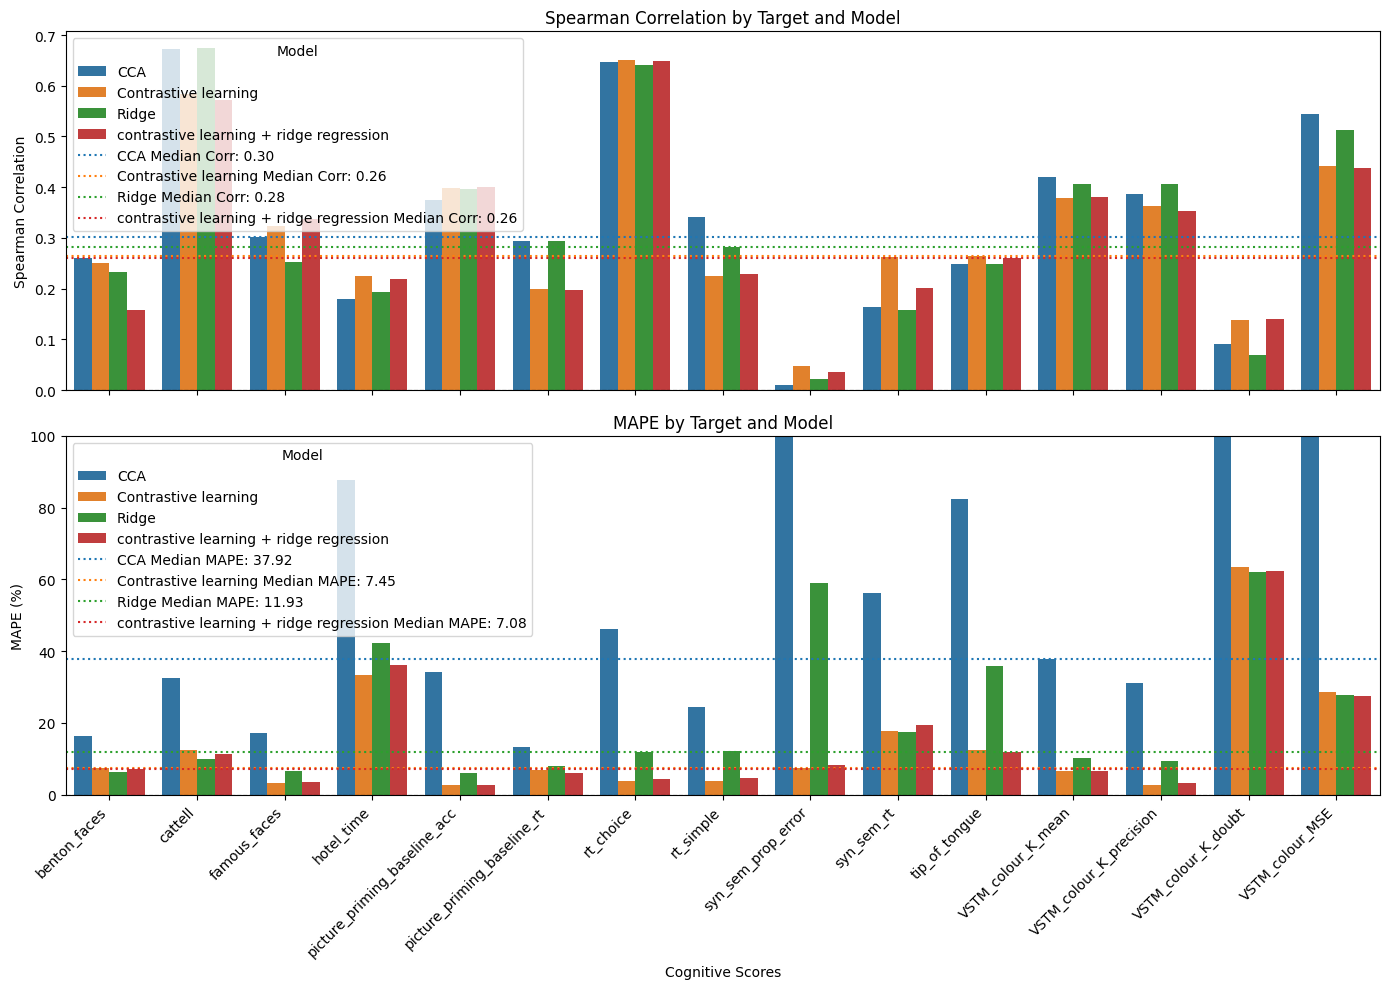

In [13]:

# List of targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Combine all datasets into one for easier processing
all_results = pd.concat(
    [
        results_ridge_df.assign(model="Ridge"),
        results_cca_df.assign(model="CCA"),
        prediction_model.assign(model="Contrastive learning"),
        final_results.assign(model = "contrastive learning + ridge regression")
    ],
    ignore_index=True,
)

# Compute Spearman correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():
                # Spearman correlation
                spearman_corr = spearmanr(true_values, predicted_values)[0]

                # MAPE (Mean Absolute Percentage Error)
                mape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute median correlation and MAPE for each model
median_stats = results_df.groupby("model")[["spearman_corr", "mape"]].median().reset_index()
median_stats.rename(columns={"spearman_corr": "median_corr", "mape": "median_mape"}, inplace=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spearman correlation plot
sns.barplot(
    data=results_df,
    x="target",
    y="spearman_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Spearman Correlation by Target and Model")
axes[0].set_ylabel("Spearman Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median Spearman correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(median_stats["model"])
}
for model, row in median_stats.iterrows():
    axes[0].axhline(
        row["median_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median MAPE
for model, row in median_stats.iterrows():
    axes[1].axhline(
        row["median_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()


/tmp/ipykernel_767230/1415683022.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


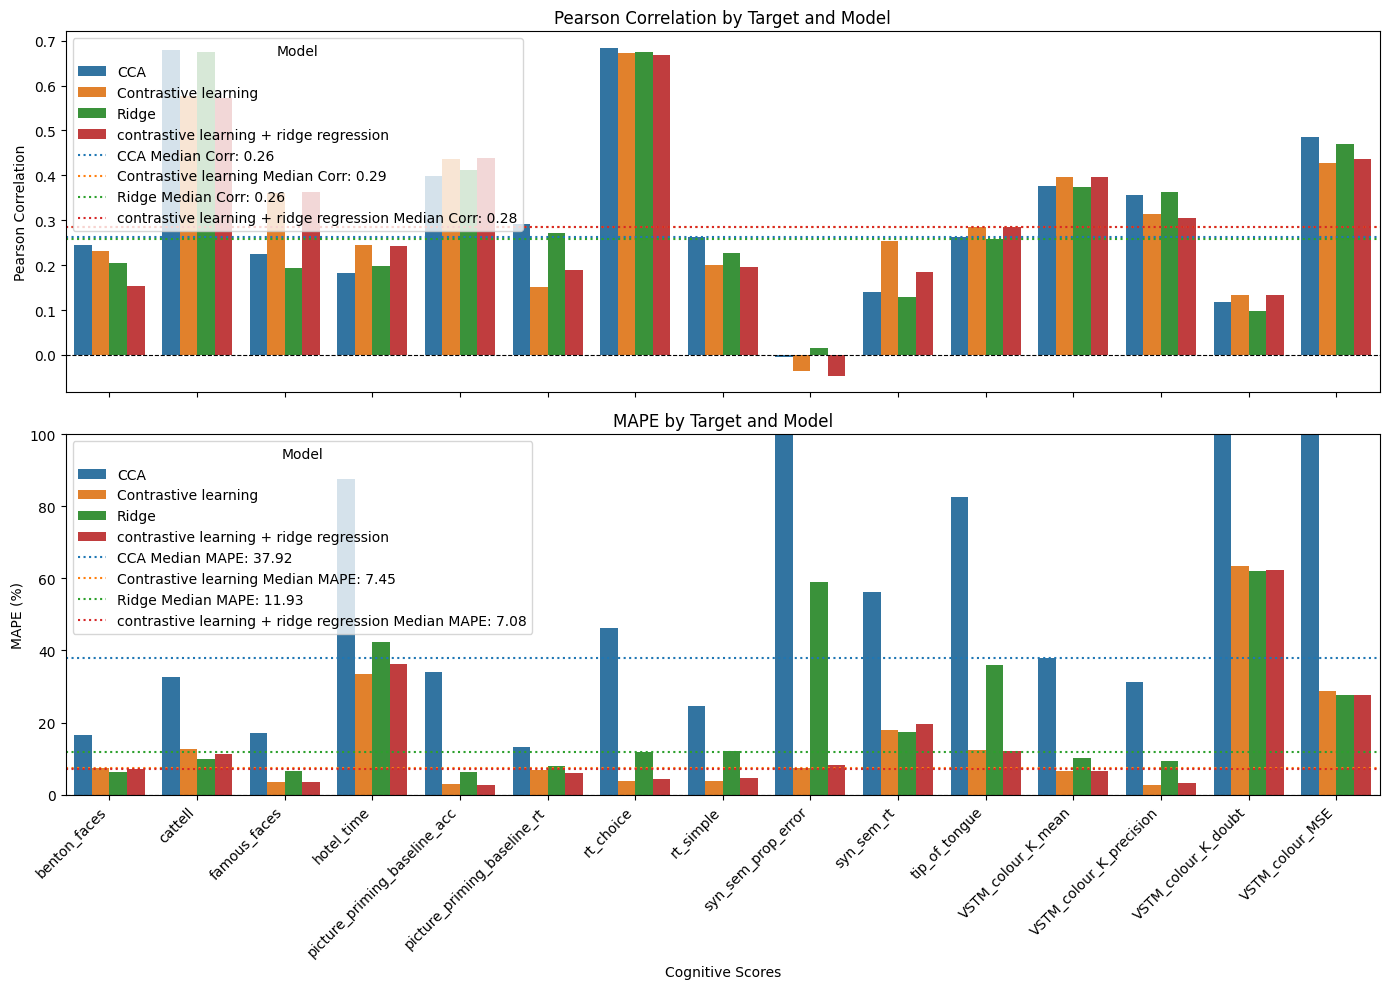

In [14]:
# Compute Pearson correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():
                # Pearson correlation
                pearson_corr = np.corrcoef(true_values, predicted_values)[0, 1]

                # MAPE (Median Absolute Percentage Error)
                mape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "pearson_corr": pearson_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute median correlation and MAPE for each model
median_stats = results_df.groupby("model")[["pearson_corr", "mape"]].median().reset_index()
median_stats.rename(columns={"pearson_corr": "median_corr", "mape": "median_mape"}, inplace=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Pearson correlation plot
sns.barplot(
    data=results_df,
    x="target",
    y="pearson_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Pearson Correlation by Target and Model")
axes[0].set_ylabel("Pearson Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median Pearson correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(median_stats["model"])
}
for model, row in median_stats.iterrows():
    axes[0].axhline(
        row["median_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median MAPE
for model, row in median_stats.iterrows():
    axes[1].axhline(
        row["median_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()


/tmp/ipykernel_473627/3730937979.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


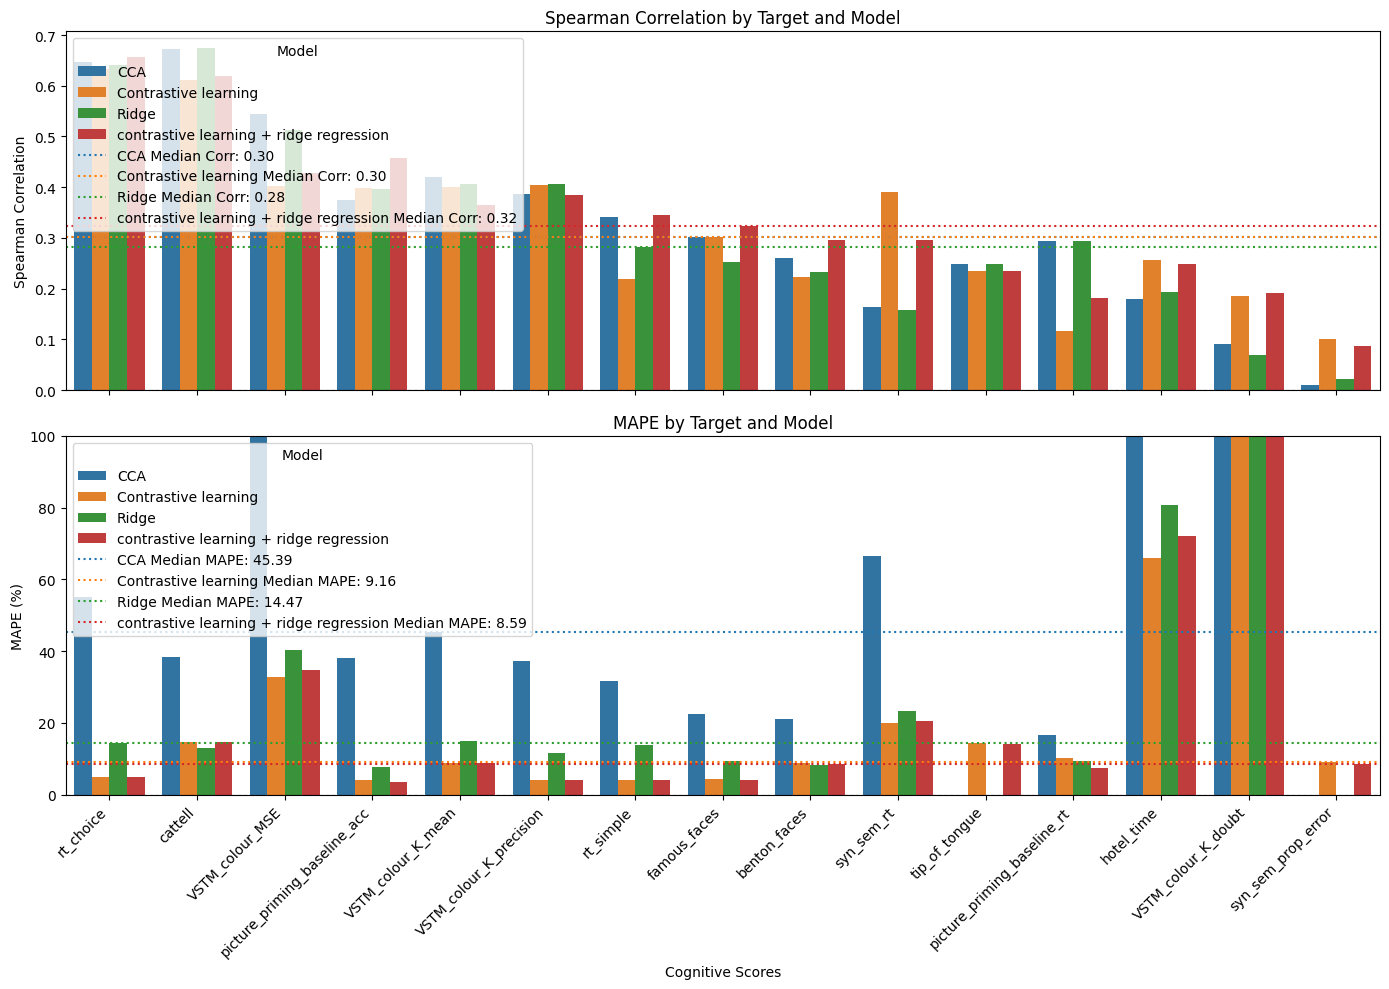

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np



# List of targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Combine all datasets into one for easier processing
all_results = pd.concat(
    [
        results_ridge_df.assign(model="Ridge"),
        results_cca_df.assign(model="CCA"),
        prediction_model.assign(model="Contrastive learning"),
        final_results.assign(model = "contrastive learning + ridge regression")
    ],
    ignore_index=True,
)

# Compute Spearman correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():

                # Spearman correlation
                spearman_corr = spearmanr(true_values, predicted_values)[0]

                # MAPE (Mean Absolute Percentage Error)
                mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute median correlation and MAPE for each model
mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].median().reset_index()
mean_stats.rename(columns={"spearman_corr": "median_corr", "mape": "median_mape"}, inplace=True)

# Calculate mean Spearman correlation and MAPE for each target across all models
target_stats = results_df.groupby("target")[["spearman_corr", "mape"]].mean().reset_index()

# Rank targets by mean Spearman correlation or MAPE
target_stats["spearman_corr_rank"] = target_stats["spearman_corr"].rank(ascending=False)
target_stats["mape_rank"] = target_stats["mape"].rank(ascending=True)

# Sorting targets by rank (use "spearman_corr_rank" or "mape_rank" for sorting)
sorted_targets_by_corr = target_stats.sort_values(by="spearman_corr_rank")["target"].tolist()
sorted_targets_by_mape = target_stats.sort_values(by="mape_rank")["target"].tolist()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spearman correlation plot (sorted by Spearman correlation)
sns.barplot(
    data=results_df,
    x="target",
    y="spearman_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
    order=sorted_targets_by_corr  # Order by Spearman correlation rank
)
axes[0].set_title("Spearman Correlation by Target and Model")
axes[0].set_ylabel("Spearman Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean Spearman correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(mean_stats["model"])
}
for model, row in mean_stats.iterrows():
    axes[0].axhline(
        row["median_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot (sorted by MAPE)
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
    order=sorted_targets_by_mape  # Order by MAPE rank
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean MAPE
for model, row in mean_stats.iterrows():
    axes[1].axhline(
        row["median_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()


In [3]:
def plot_scores(ridge, cca, model, targets):
    all_results = pd.concat(
    [
        ridge.assign(model="Ridge"),
        cca.assign(model="CCA"),
        model.assign(model="Contrastive learning"),
    ],
    ignore_index=True,
    )

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():

                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Compute median correlation and MAPE for each model
    mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].mean().reset_index()
    mean_stats.rename(columns={"spearman_corr": "mean_corr", "mape": "mean_mape"}, inplace=True)

    # Calculate mean Spearman correlation and MAPE for each target across all models
    target_stats = results_df.groupby("target")[["spearman_corr", "mape"]].mean().reset_index()

    # Rank targets by mean Spearman correlation or MAPE
    target_stats["spearman_corr_rank"] = target_stats["spearman_corr"].rank(ascending=False)
    target_stats["mape_rank"] = target_stats["mape"].rank(ascending=True)

    # Sorting targets by rank (use "spearman_corr_rank" or "mape_rank" for sorting)
    sorted_targets_by_corr = target_stats.sort_values(by="spearman_corr_rank")["target"].tolist()
    sorted_targets_by_mape = target_stats.sort_values(by="mape_rank")["target"].tolist()

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette="tab10",
        order=sorted_targets_by_corr  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean Spearman correlation
    palette = sns.color_palette("tab10")
    model_colors = {
        model: palette[i] for i, model in enumerate(mean_stats["model"])
    }
    for model, row in mean_stats.iterrows():
        axes[0].axhline(
            row["mean_corr"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Mean Corr: {row['mean_corr']:.2f}",
        )

    # Update legend
    axes[0].legend(title="Model", loc="upper left")

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette="tab10",
        order=sorted_targets_by_mape  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean MAPE
    for model, row in mean_stats.iterrows():
        axes[1].axhline(
            row["mean_mape"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Mean MAPE: {row['mean_mape']:.2f}",
        )

    # Limit MAPE y-axis to 100
    axes[1].set_ylim(0, 100)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Update legend
    axes[1].legend(title="Model", loc="upper left")

    plt.tight_layout()
    plt.show()
    

In [4]:
def plot_median_scores(ridge, cca, model, targets):
    all_results = pd.concat(
    [
        ridge.assign(model="Ridge"),
        cca.assign(model="CCA"),
        model.assign(model="Contrastive learning"),
    ],
    ignore_index=True,
    )

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():

                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Compute median correlation and MAPE for each model
    mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].median().reset_index()
    mean_stats.rename(columns={"spearman_corr": "median_corr", "mape": "median_mape"}, inplace=True)

    # Calculate mean Spearman correlation and MAPE for each target across all models
    target_stats = results_df.groupby("target")[["spearman_corr", "mape"]].mean().reset_index()

    # Rank targets by mean Spearman correlation or MAPE
    target_stats["spearman_corr_rank"] = target_stats["spearman_corr"].rank(ascending=False)
    target_stats["mape_rank"] = target_stats["mape"].rank(ascending=True)

    # Sorting targets by rank (use "spearman_corr_rank" or "mape_rank" for sorting)
    sorted_targets_by_corr = target_stats.sort_values(by="spearman_corr_rank")["target"].tolist()
    sorted_targets_by_mape = target_stats.sort_values(by="mape_rank")["target"].tolist()

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette="tab10",
        order=sorted_targets_by_corr  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean Spearman correlation
    palette = sns.color_palette("tab10")
    model_colors = {
        model: palette[i] for i, model in enumerate(mean_stats["model"])
    }
    for model, row in mean_stats.iterrows():
        axes[0].axhline(
            row["median_corr"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
        )

    # Update legend
    axes[0].legend(title="Model", loc="upper left")

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette="tab10",
        order=sorted_targets_by_mape  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean MAPE
    for model, row in mean_stats.iterrows():
        axes[1].axhline(
            row["median_mape"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
        )

    # Limit MAPE y-axis to 100
    axes[1].set_ylim(0, 100)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Update legend
    axes[1].legend(title="Model", loc="upper left")

    plt.tight_layout()
    plt.show()
    

## Different residual plots

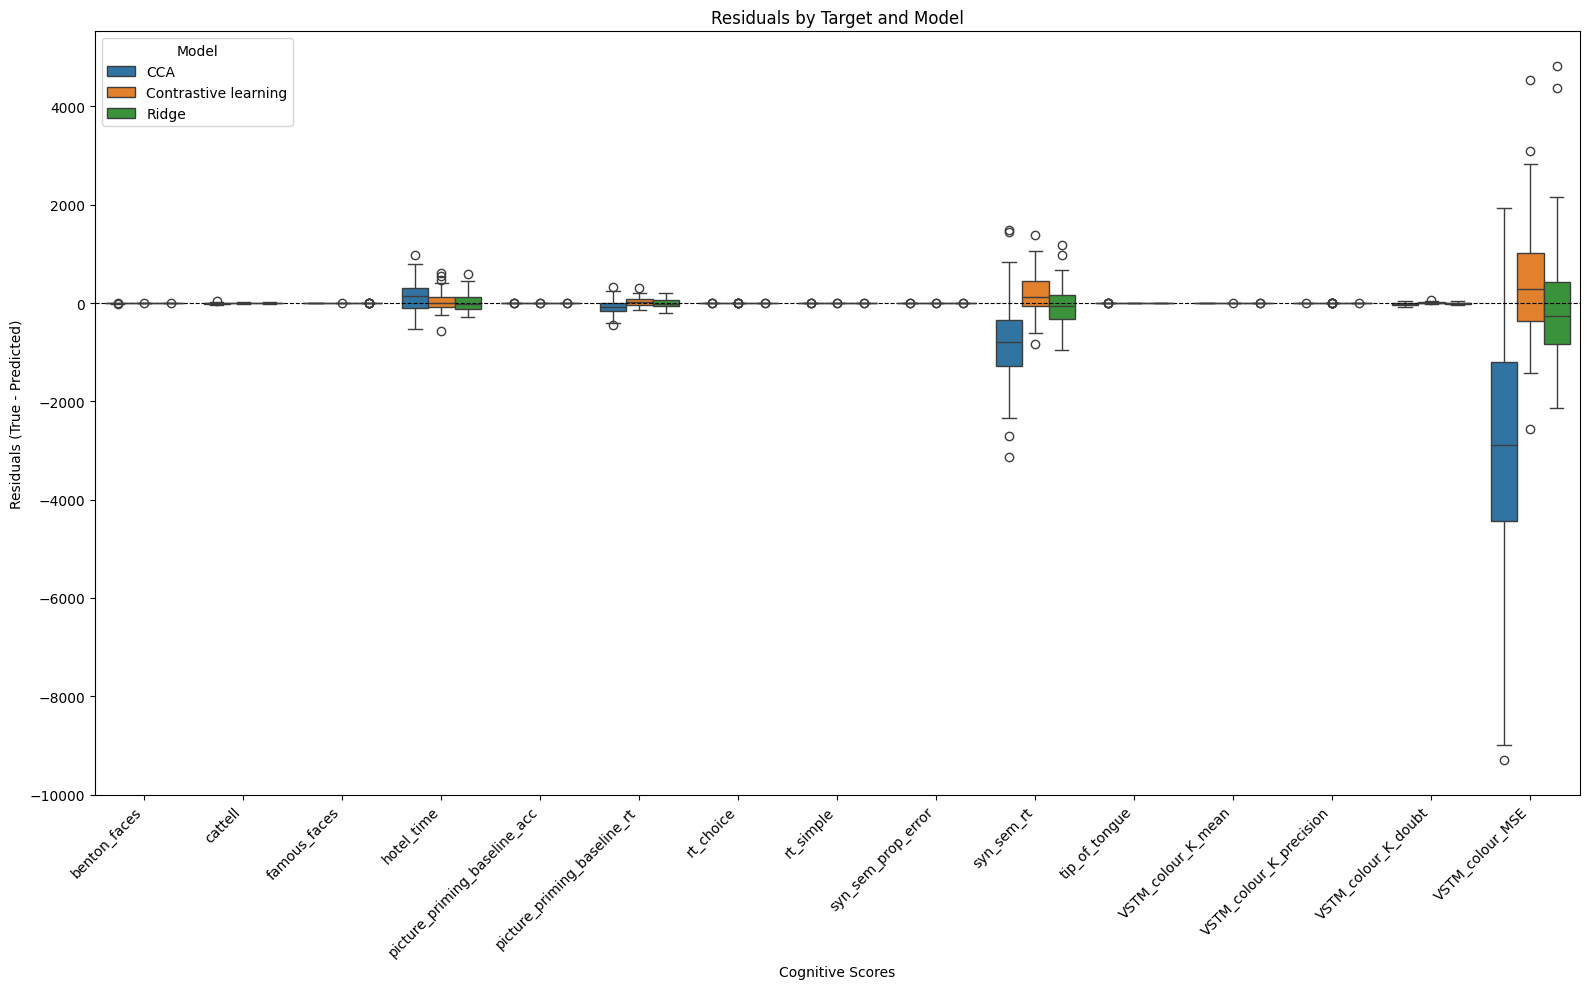

In [22]:
# Compute residuals for each target and model
residuals_list = []
for target in targets:
    for model, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]
        if target in test_data.columns:
            residuals = test_data[target] - test_data[f"{target}_pred"]
            residuals_list.append(
                pd.DataFrame({
                    "residual": residuals,
                    "target": target,
                    "model": model
                })
            )

# Combine residuals into a single DataFrame
residuals_df = pd.concat(residuals_list, ignore_index=True)

# Plot residuals
plt.figure(figsize=(16, 10))

sns.boxplot(
    data=residuals_df,
    x="target",
    y="residual",
    hue="model",
    palette="tab10"
)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line at zero residual
plt.title("Residuals by Target and Model")
plt.ylabel("Residuals (True - Predicted)")
plt.xlabel("Cognitive Scores")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels to avoid overlap
plt.legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()



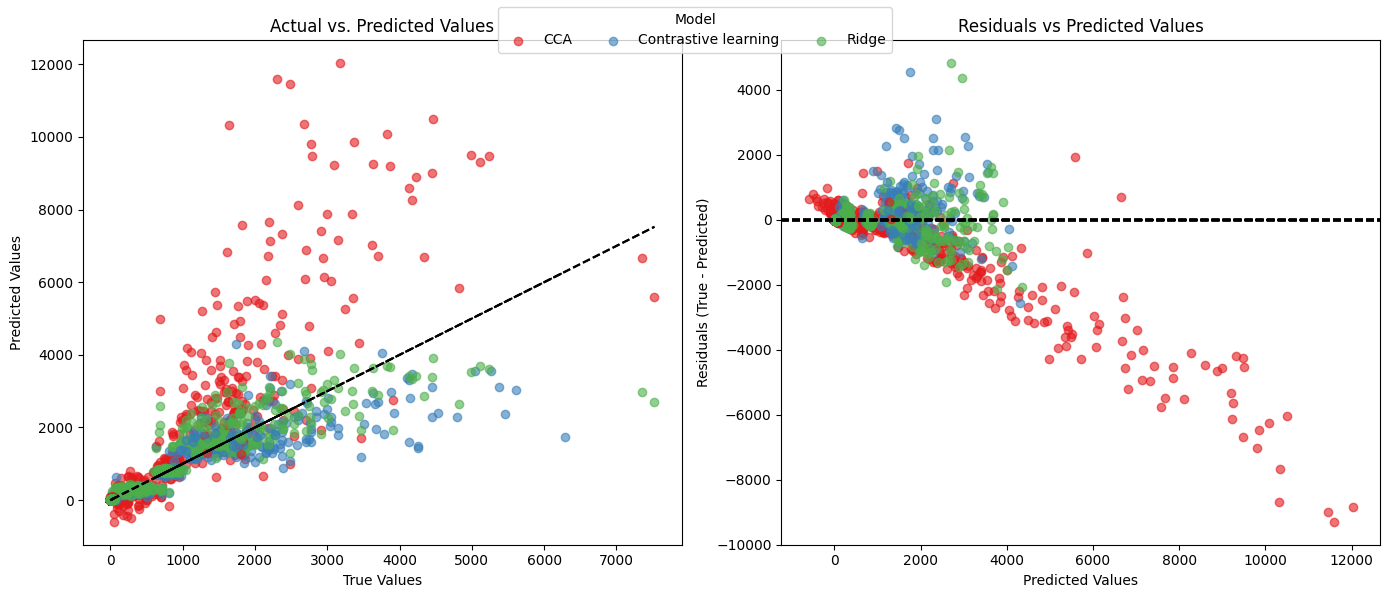

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define a color palette to assign a unique color to each model
palette = sns.color_palette("Set1", n_colors=len(all_results["model"].unique()))

# Prepare for plotting
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

# Initialize empty lists to collect legend handles and labels
handles, labels = [], []

# Loop through each model and target
for target in targets:
    for i, (model, group) in enumerate(all_results.groupby("model")):
        test_data = group[group["dataset"] == "test"]
        
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]
            residuals = true_values - predicted_values
            
            # Plot Actual vs Predicted
            scatter1 = axs[0].scatter(true_values, predicted_values, label=model, color=palette[i], alpha=0.6)
            axs[0].set_xlabel("True Values")
            axs[0].set_ylabel("Predicted Values")
            axs[0].set_title("Actual vs. Predicted Values")
            axs[0].plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], linestyle="--", color="k")
            
            # Plot Residuals vs Predicted
            scatter2 = axs[1].scatter(predicted_values, residuals, label=model, color=palette[i], alpha=0.6)
            axs[1].set_xlabel("Predicted Values")
            axs[1].set_ylabel("Residuals (True - Predicted)")
            axs[1].set_title("Residuals vs Predicted Values")
            axs[1].axhline(0, color="k", linestyle="--")

            # Collect handles and labels for the legend (only once per model)
            if model not in labels:
                handles.append(scatter1)
                labels.append(model)

# Add a shared legend for both plots
fig.legend(handles, labels, title="Model", loc="upper center", ncol=3)

# Adjust layout to ensure the figure and legend fit nicely
plt.tight_layout()
plt.show()




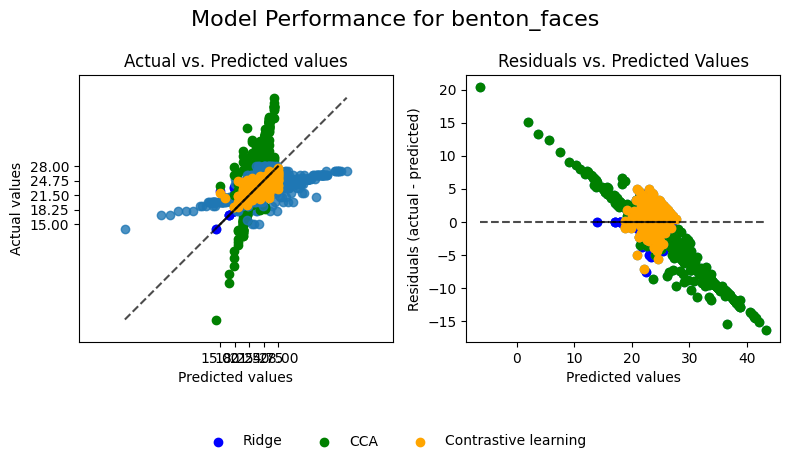

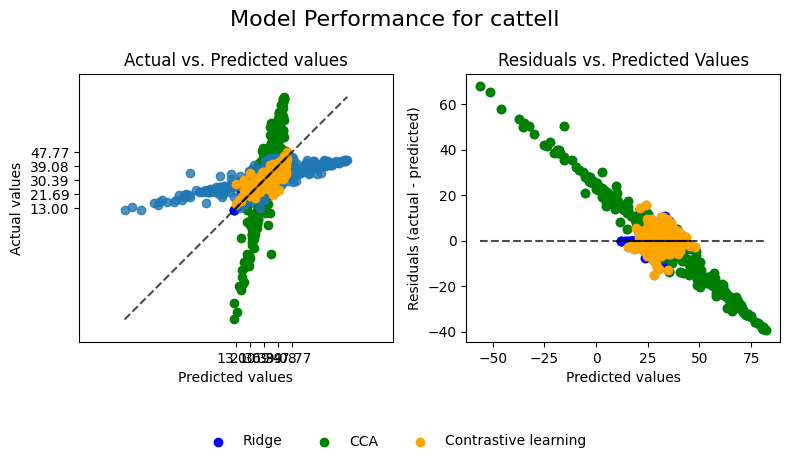

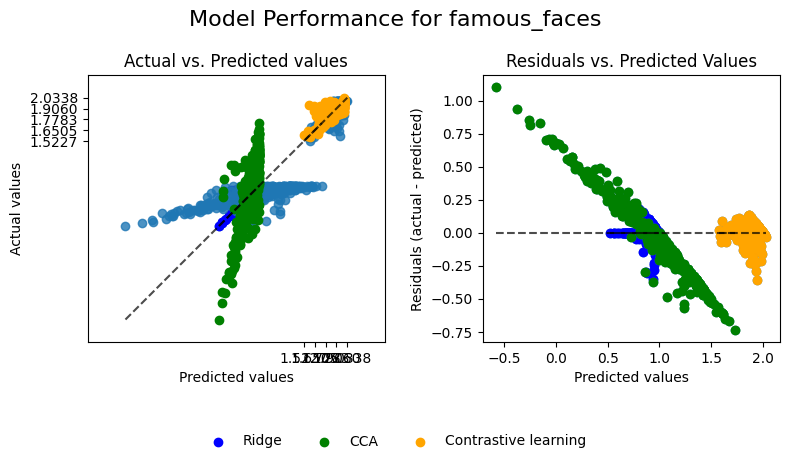

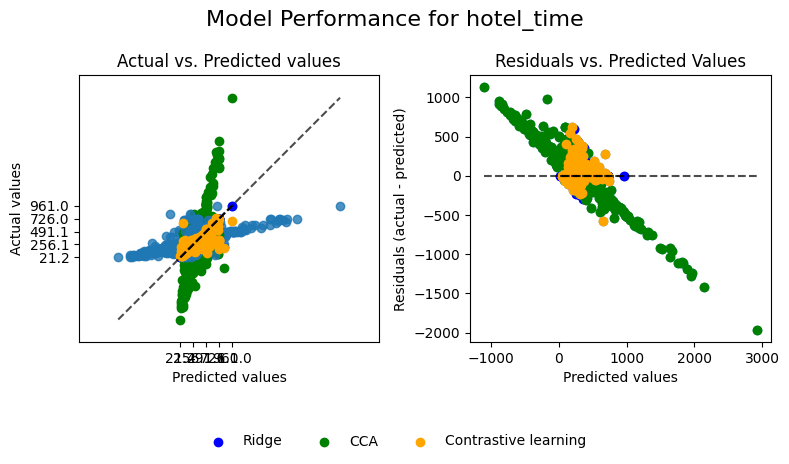

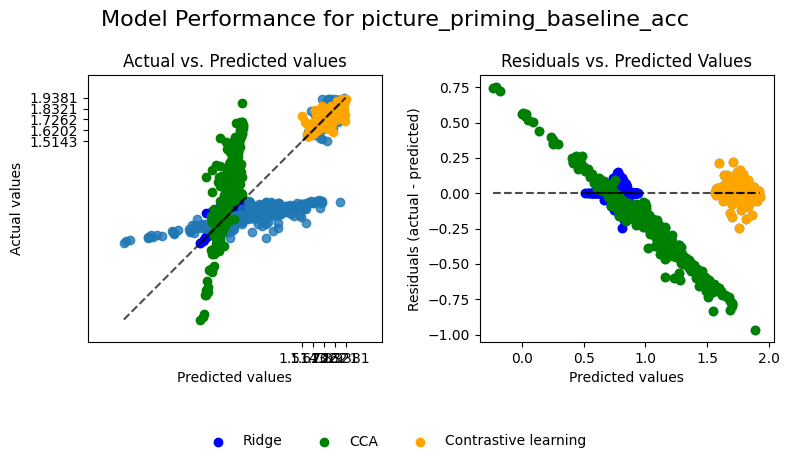

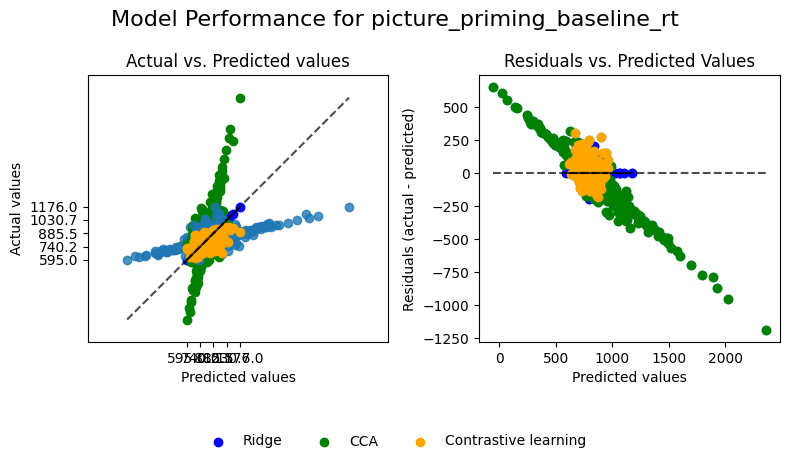

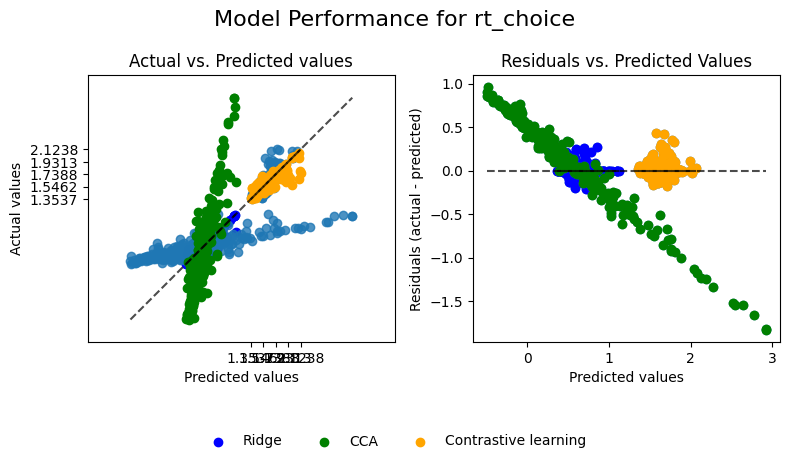

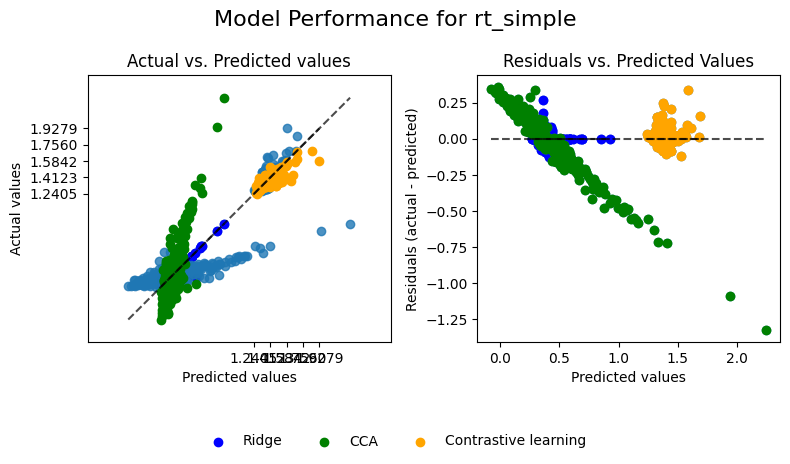

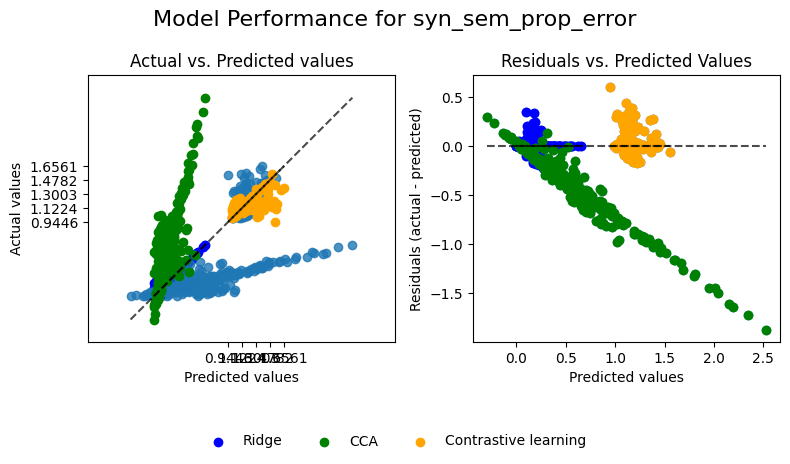

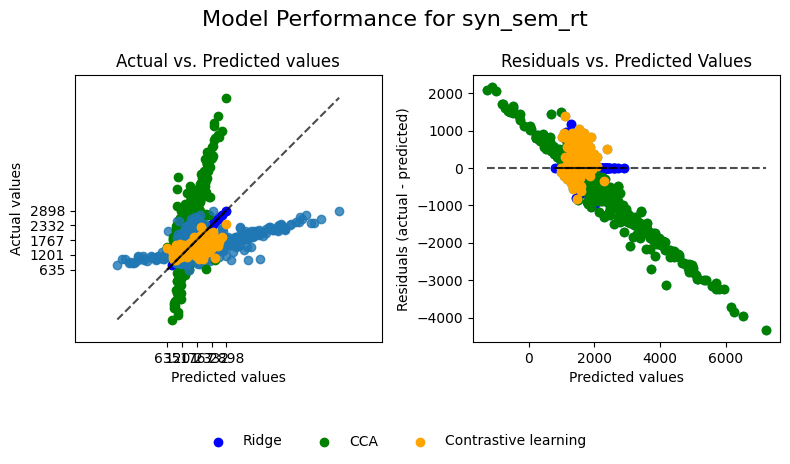

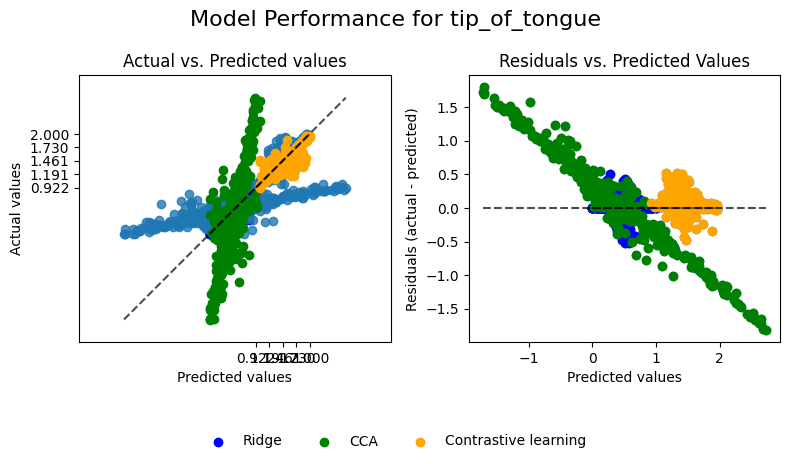

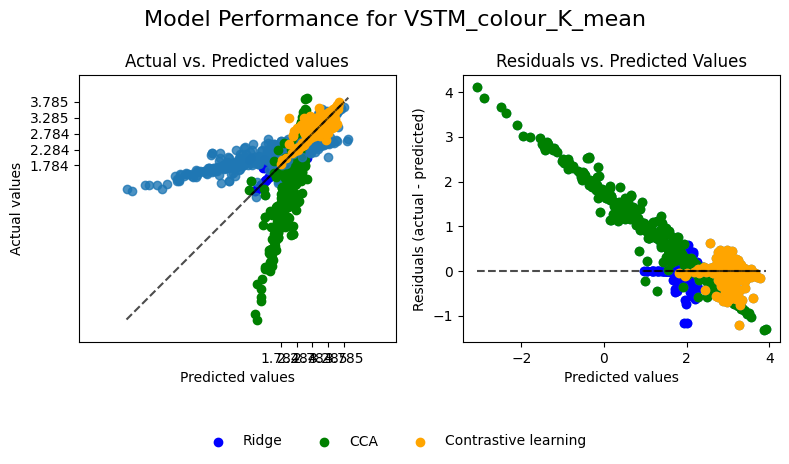

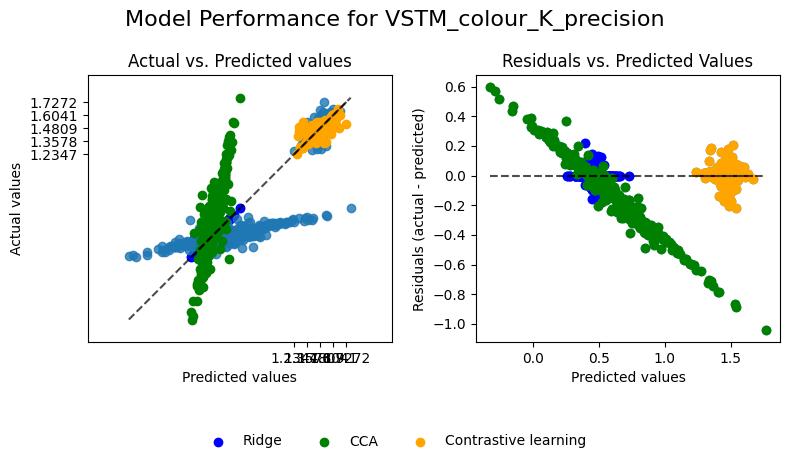

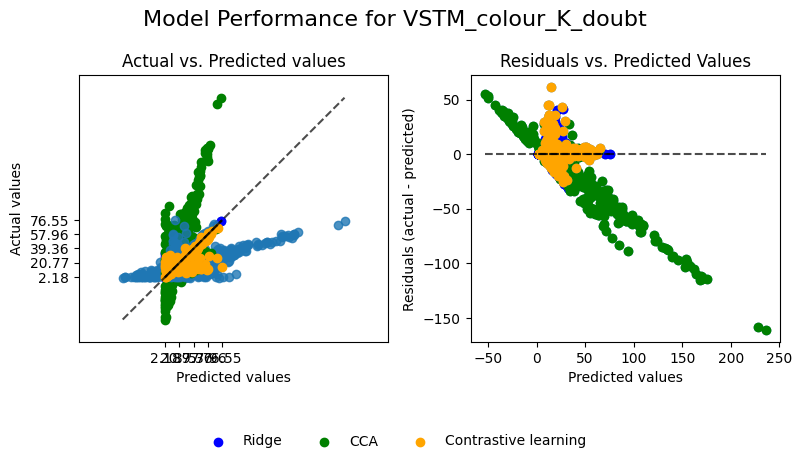

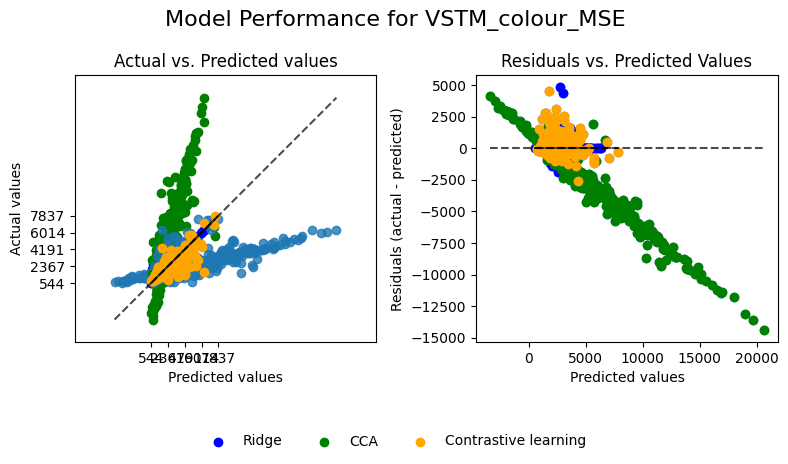

In [39]:
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt

# Define a color map for the datasets
dataset_colors = {
    "Ridge": "blue", 
    "CCA": "green", 
    "Contrastive learning": "orange"
}

# Loop over each target and create a figure for each
for target in targets:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    
    # Loop through each model and plot the actual vs predicted and residuals vs predicted
    for model, color in dataset_colors.items():
        # Get the true values and predicted values for the current model
        model_data = all_results[all_results["model"] == model]  # Filter by model
        
        # Ensure target column exists and extract the actual and predicted values
        if target in model_data.columns and f"{target}_pred" in model_data.columns:
            y_test = model_data[target]  # Actual values for the current target and model
            y_pred = model_data[f"{target}_pred"]  # Predicted values for the current target and model

            # Plot Actual vs. Predicted values
            disp = PredictionErrorDisplay.from_predictions(
                y_test,
                y_pred=y_pred,
                kind="actual_vs_predicted",
                subsample=500,
                ax=axs[0],
                random_state=0
            )
            # Modify appearance: color and marker
            disp.ax_.scatter(y_test, y_pred, color=color, marker='o', label=model)
            
            # Plot Residuals vs. Predicted values
            disp = PredictionErrorDisplay.from_predictions(
                y_test,
                y_pred=y_pred,
                kind="residual_vs_predicted",
                subsample=500,
                ax=axs[1],
                random_state=0
            )
            # Modify appearance: color and marker
            disp.ax_.scatter(y_pred, y_test - y_pred, color=color, marker='o', label=model)

    # Set plot titles
    axs[0].set_title("Actual vs. Predicted values")
    axs[1].set_title("Residuals vs. Predicted Values")
    
    fig.suptitle(f"Model Performance for {target}", fontsize=16)
    
    # Add a single legend for both plots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)
    
    # Adjust the layout to prevent overlap (leave space for the legend)
    plt.tight_layout()
    
    # Adjust subplots to make space for the legend
    plt.subplots_adjust(bottom=0.15)
    
    # Display the plots for the current target
    plt.show()




# Comparisons with different sample sizes

In [ ]:
#Contrastive learning prediction results
cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")
cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

## Preparing preds for CV Ridge regression and CCA

In [52]:
def prepare_data(dataset_path, targets):
    dataset = MatData(dataset_path, targets, synth_exp = False, threshold=0)

    n_sub = len(dataset)
    indices = np.arange(n_sub)

    train_size = int(n_sub * (1 - test_ratio) * train_ratio)
    test_size = int(test_ratio * n_sub)
    run_size = test_size + train_size

    random_state = np.random.RandomState(seed=42)
    run_indices = random_state.choice(indices, run_size, replace=False)
    train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
    X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
    y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()
    X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
    X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
    y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()

    return X_train, y_train, X_test, y_test
        

In [53]:
def ridge_pred(X_train, y_train, X_test, y_test) :
    
    ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")

    pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

    fitted_pipe = pipe_ridge.fit(X_train, y_train)

    y_train_pred = fitted_pipe.predict(X_train)
    y_test_pred = fitted_pipe.predict(X_test)

    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    # Combine train and test results into a single DataFrame
    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

In [54]:
def cca_pred(X_train, y_train, X_test, y_test):
    n_components = min(len(targets), X_train.shape[1])  
    pipe_cca = Pipeline([
        ('scaler', StandardScaler()),  
        ('cca', CCA(n_components=n_components))
    ])

    pipe_cca.fit(X_train, y_train)
    cca_model = pipe_cca.named_steps['cca']

    y_train_pred = cca_model.predict(X_train)
    y_test_pred = cca_model.predict(X_test)
    
    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)


### 100 samples

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


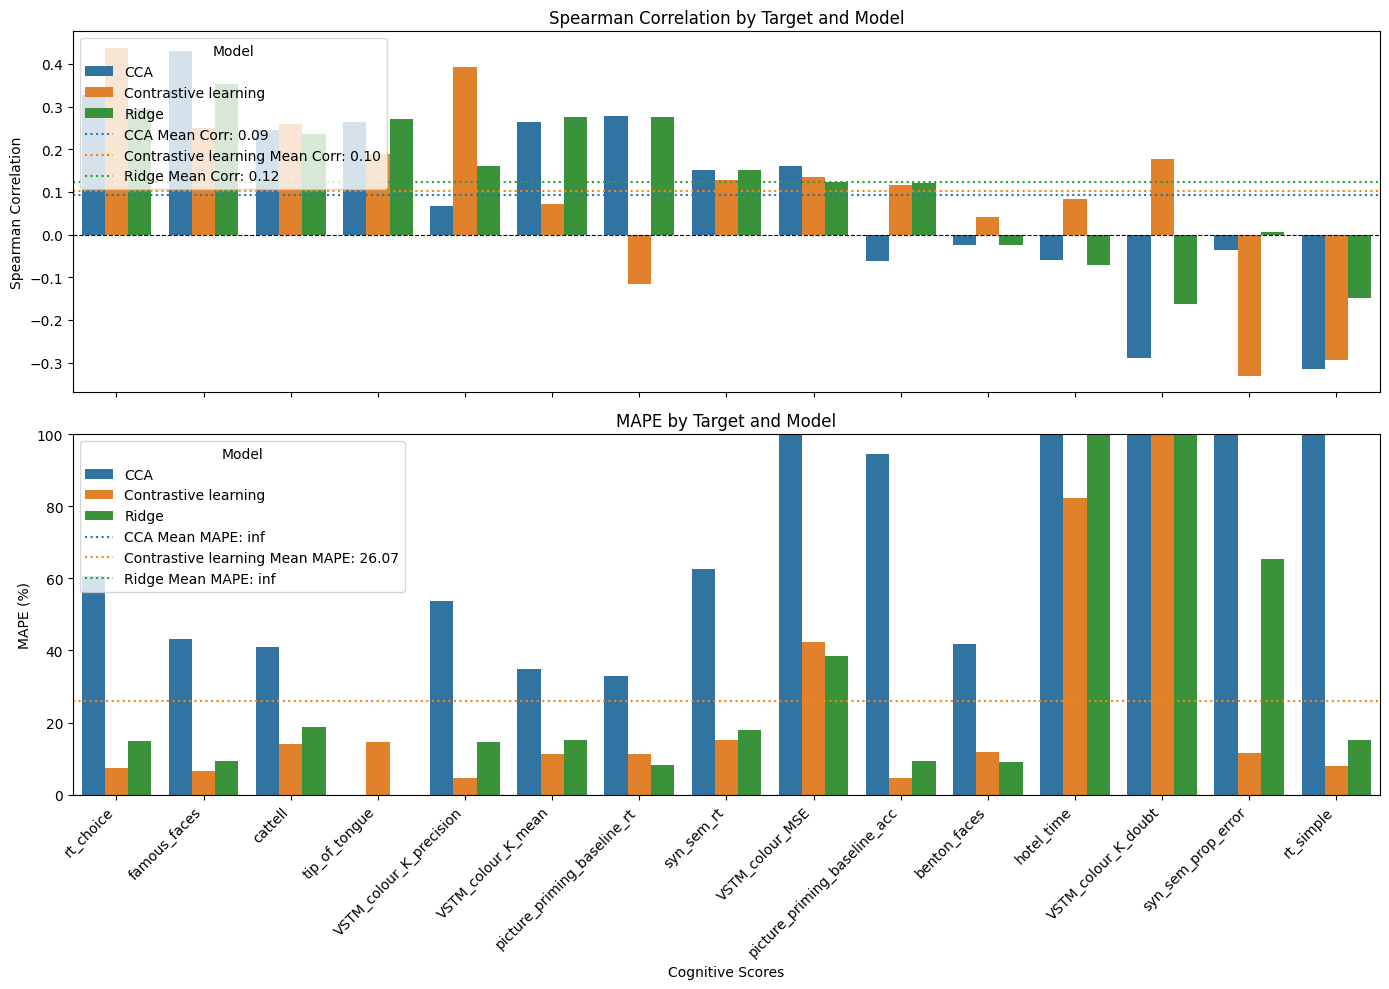

In [42]:
dataset_path = f"{root}/new_dataset_100_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_100 = ridge_pred(X_train, y_train, X_test, y_test)

cca_100 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")

plot_scores(ridge_100, cca_100, cr_pred_100, targets)


/tmp/ipykernel_767230/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


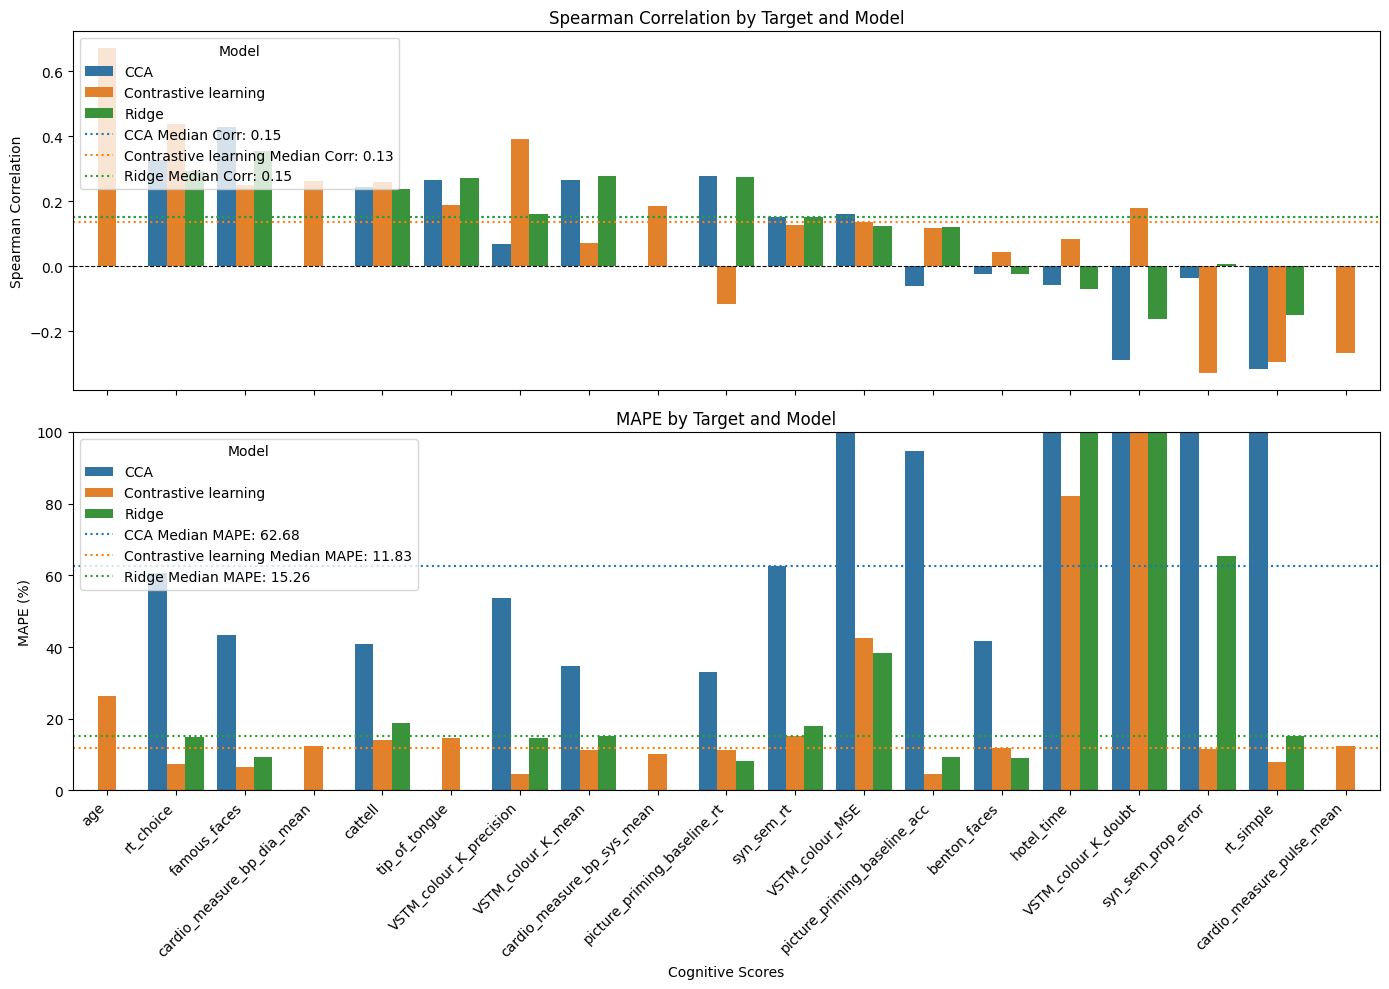

In [48]:
plot_median_scores(ridge_100, cca_100, cr_pred_100, targets)


### 200 samples

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


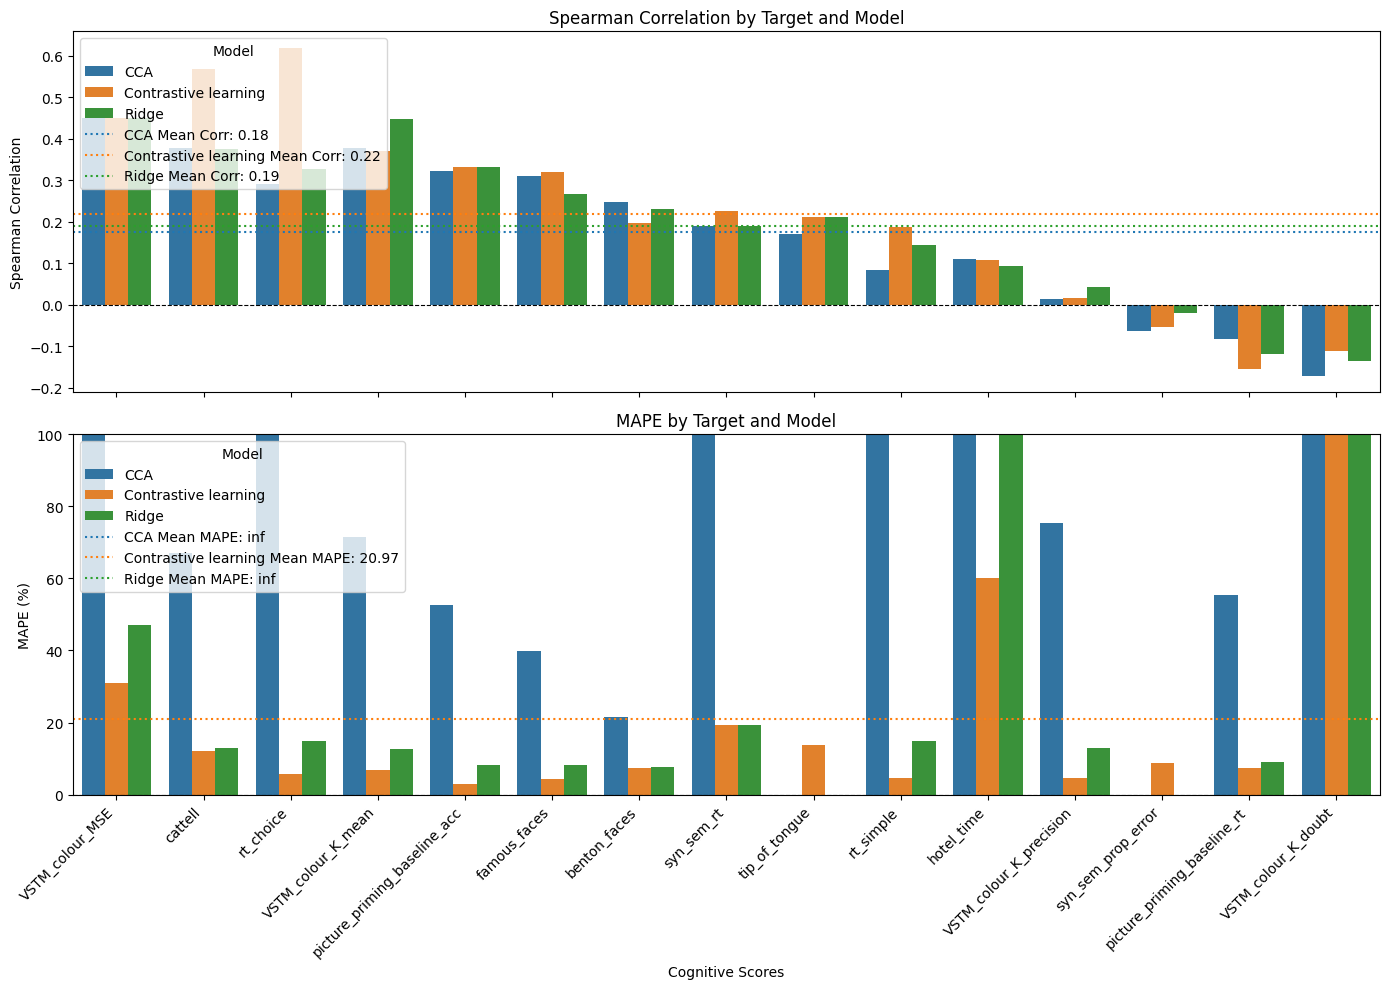

In [43]:
dataset_path = f"{root}/new_dataset_200_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_200 = ridge_pred(X_train, y_train, X_test, y_test)

cca_200 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")

plot_scores(ridge_200, cca_200, cr_pred_200, targets)


/tmp/ipykernel_767230/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


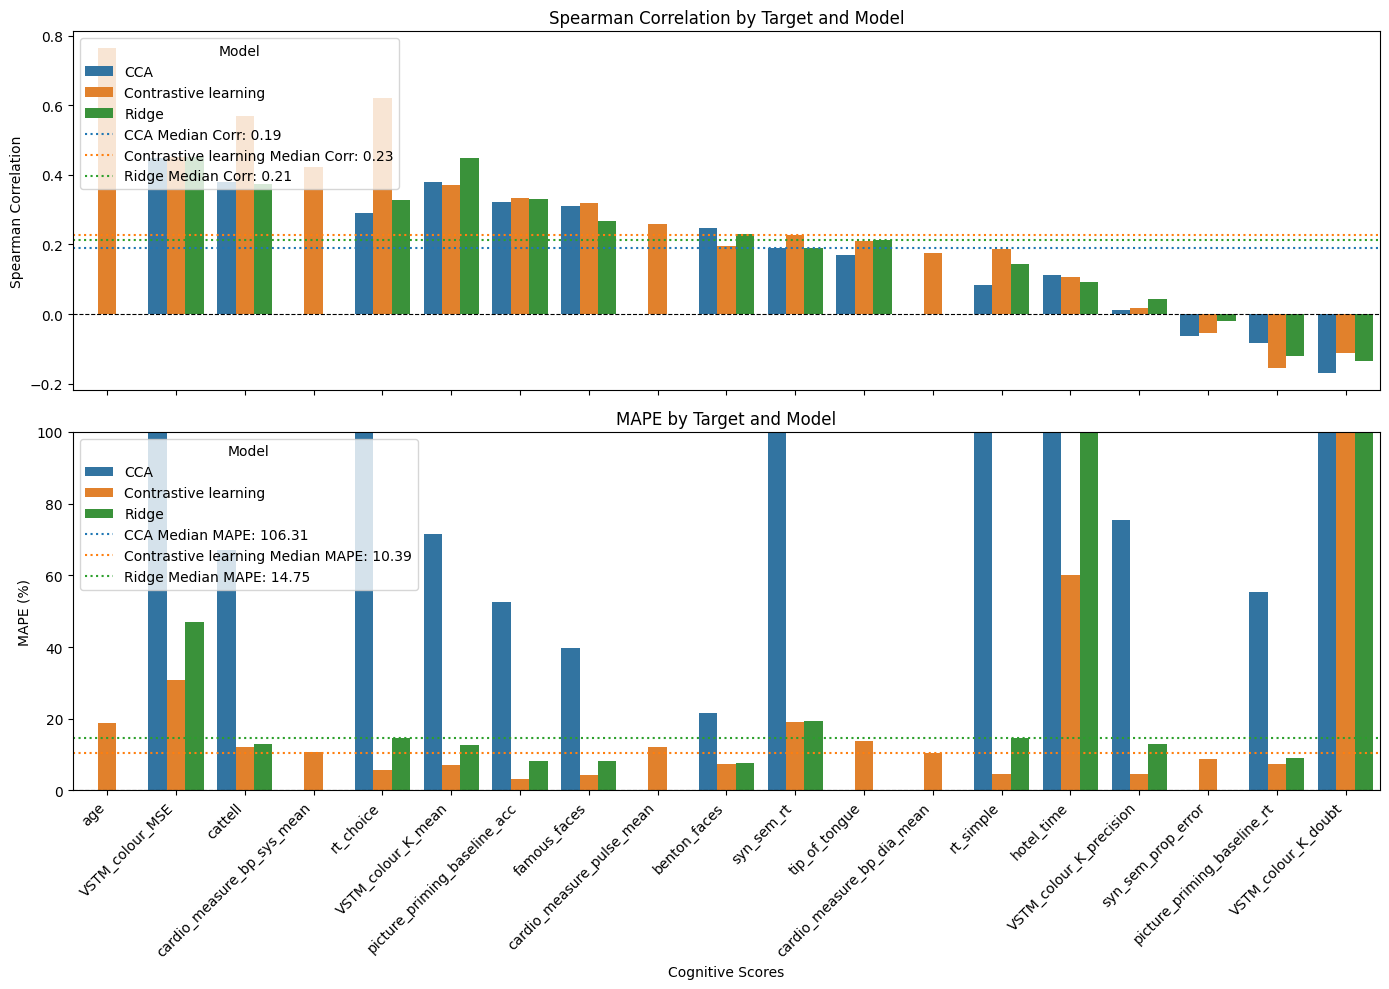

In [49]:
plot_median_scores(ridge_200, cca_200, cr_pred_200, targets)

## Whole dataset

/tmp/ipykernel_1897087/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


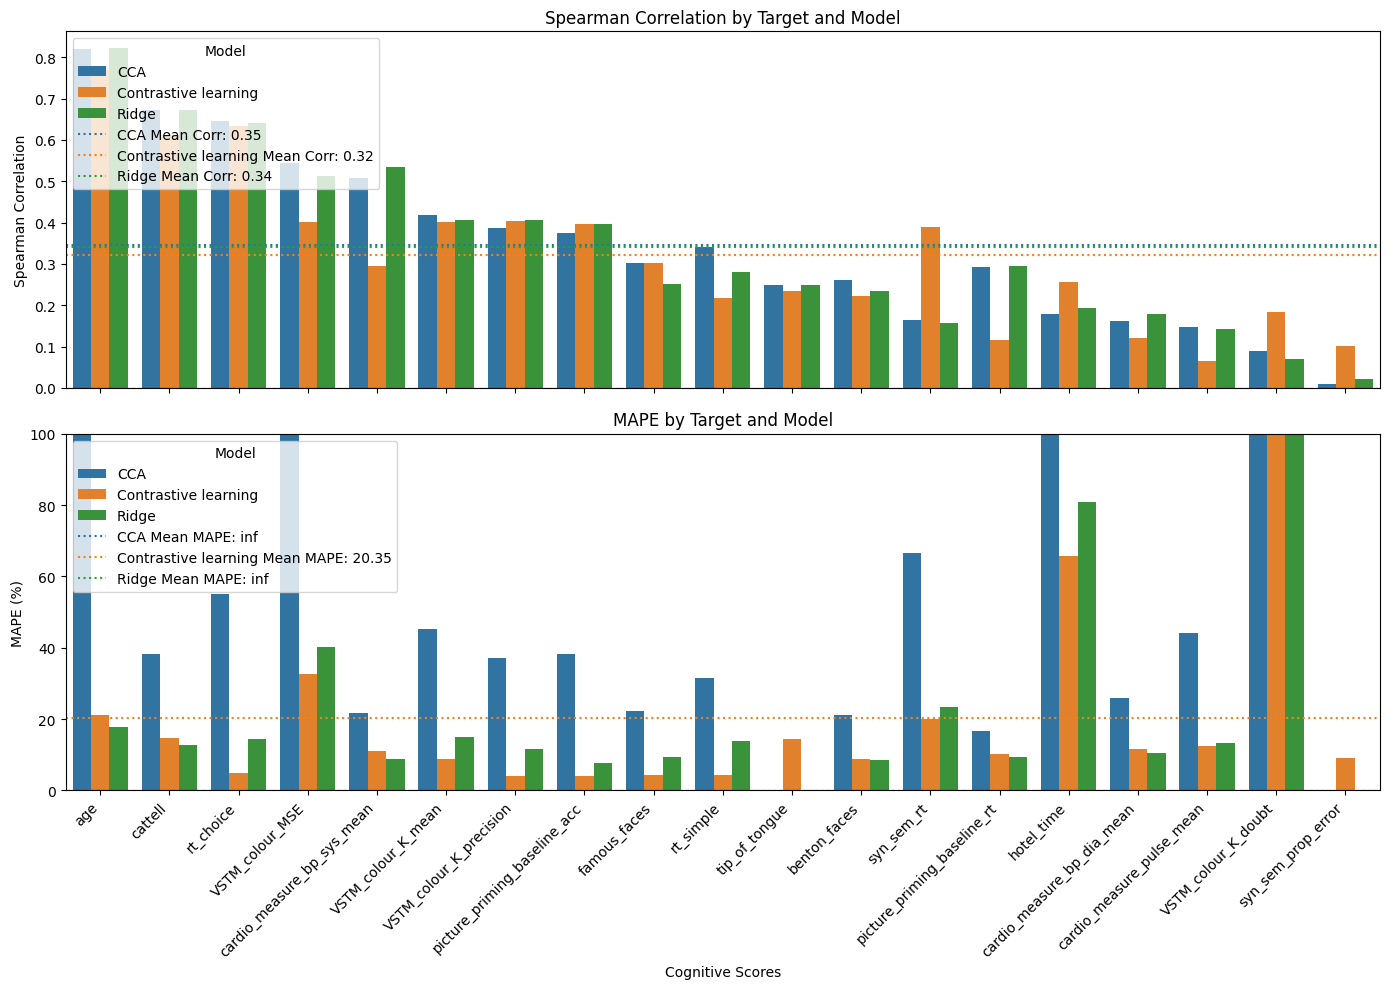

In [59]:
dataset_path = f"{root}/dataset_400parcels_3.nc"

targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_whole = ridge_pred(X_train, y_train, X_test, y_test)

cca_whole = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

plot_scores(ridge_whole, cca_whole, cr_pred_whole, targets)

In [62]:
cr_pred_2 = pd.read_csv("/data/parietal/store2/work/mrenaudi/contrastive-reg-3/results/final model : target decoding with skip connections/pred_results.csv")

/tmp/ipykernel_1897087/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


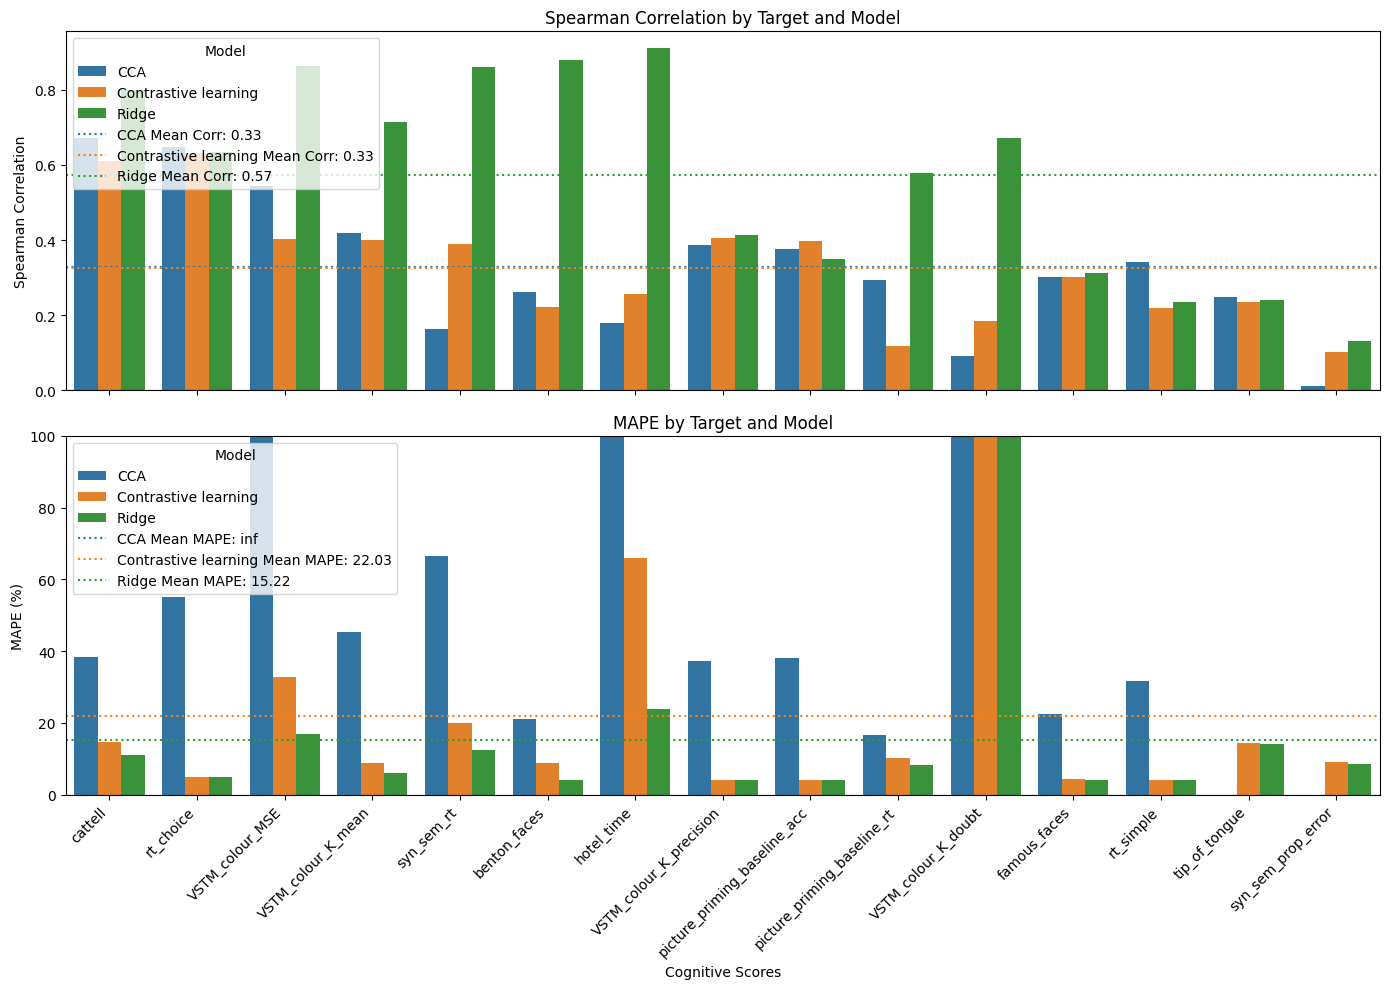

In [81]:
plot_scores(model_and_cca, cca_whole, cr_pred_whole, targets)

/tmp/ipykernel_1113666/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


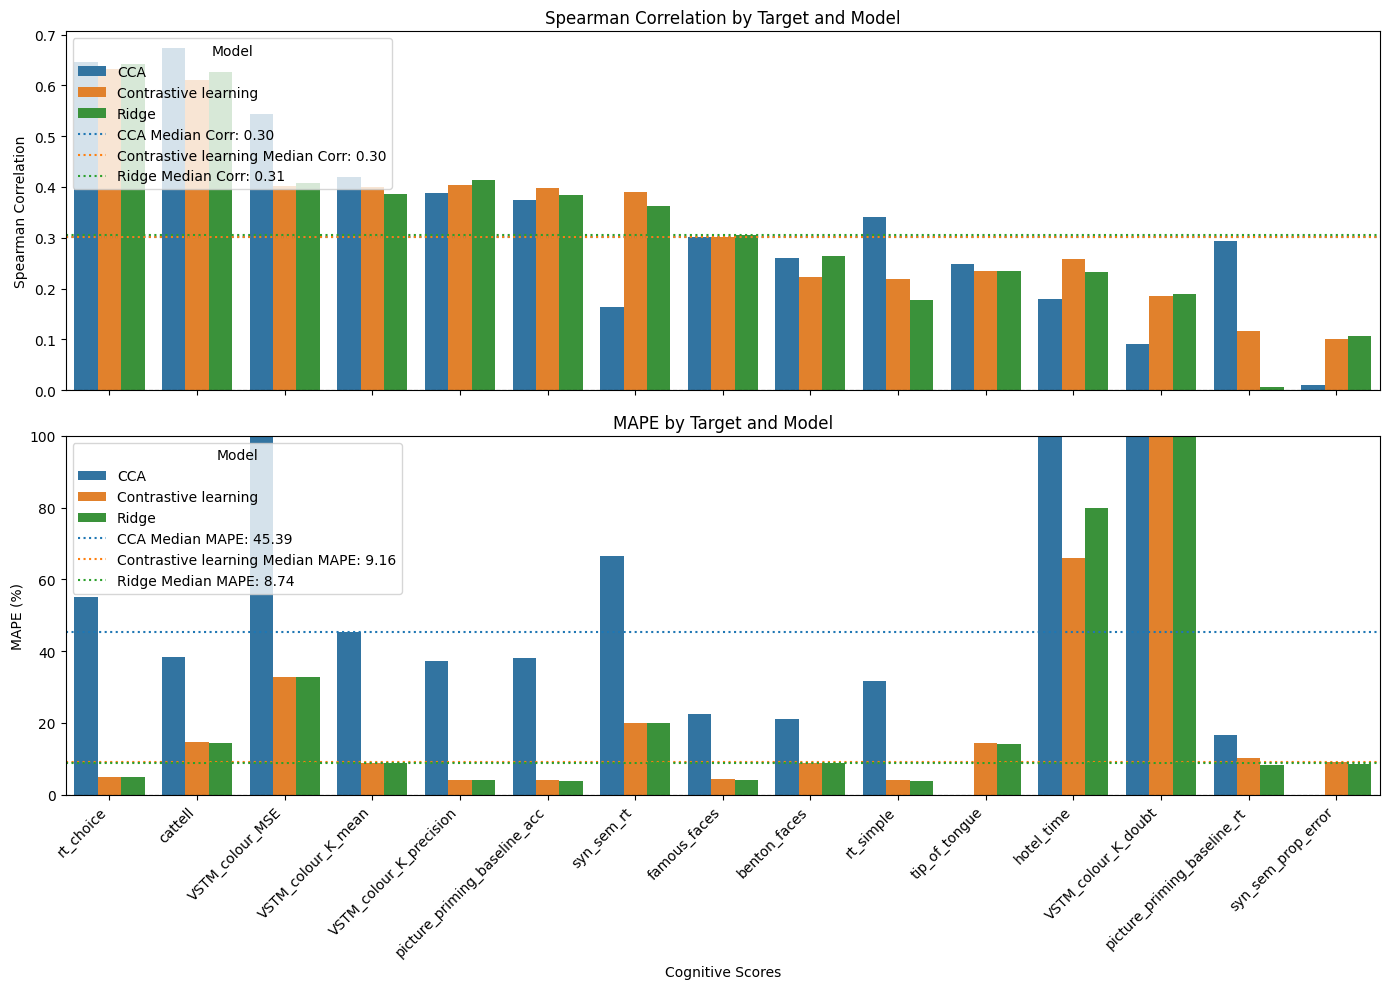

In [74]:
plot_median_scores(model_and_cca, cca_whole, cr_pred_whole, targets)

In [90]:
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")


# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure all target and prediction columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Perform CCA
#cca = CCA(n_components=len(target_cols))  # Number of components should match the number of targets
#cca.fit(y_train, X_train)
pipe_cca = Pipeline([
        ('scaler', StandardScaler()),  
        ('cca', CCA(n_components=len(target_cols)))
    ])

pipe_cca.fit(X_train, y_train)
cca_model = pipe_cca.named_steps['cca']

X_c_train = cca_model.transform(X_train)
X_c_test = cca_model.transform (X_test)
#y_train_pred = cca_model.inverse_transform(X_c_train)

ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")

pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

fitted_pipe = pipe_ridge.fit(X_c_train, y_train)

y_train_pred = fitted_pipe.predict(X_c_train)
y_test_pred = fitted_pipe.predict(X_c_test)

#X_c_test = cca_model.transform (X_test)
#y_test_pred = cca_model.inverse_transform(X_c_test)
# Predict targets from predicted values
# y_train_pred = cca.predict(X_train)
# y_test_pred = cca.predict(X_test)

In [78]:
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Define residuals
residuals_train = y_train - X_train  # Original targets - predicted values

# Calculate residual variance for each target
residual_variances = np.var(residuals_train, axis=0)

# Create weights inversely proportional to the residual variance
weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# Custom scorer combining Spearman correlation and MAPE with weights
def custom_scorer_weighted(y_true, y_pred):
    spearman_corrs = np.array([
        spearmanr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])
    ])
    mape = mean_absolute_percentage_error(y_true, y_pred)
    weighted_spearman = np.sum(weights_normalized * spearman_corrs)
    return (1 - weighted_spearman) #+ mape

# Huber Regressor for residuals
huber_model = HuberRegressor()

# Cross-validate with weighted custom scorer
param_grid = {
    "epsilon": [1.35, 1.5, 2.0],  # Huber loss epsilon (the threshold between quadratic and linear loss)
    "alpha": [0.1, 1.0, 10.0]  # Regularization strength
}
grid_search_huber = GridSearchCV(
    huber_model,
    param_grid=param_grid,
    cv=5,
    scoring="r2"
)

# Fit the model to residuals
fitted_huber = grid_search_huber.fit(X_train, residuals_train)

# Predict residuals for train and test sets
residuals_train_pred = fitted_huber.predict(X_train)
residuals_test_pred = fitted_huber.predict(X_test)

# Correct predictions
y_train_pred = X_train + residuals_train_pred  # Add predicted residuals to initial predictions
y_test_pred = X_test + residuals_test_pred

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")


ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py", line 297, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1318, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1339, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1406, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (196, 15) instead.

--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py", line 297, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1318, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1339, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1406, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (197, 15) instead.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")
#cr_pred_whole = pd.read_csv("/data/parietal/store2/work/mrenaudi/contrastive-reg-3/results/final model : target decoding with skip connections/pred_results.csv")
# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]



# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Define residuals
residuals_train = y_train - X_train  # Original targets - predicted values

# Calculate residual variance for each target
residual_variances = np.var(residuals_train, axis=0)

# Create weights inversely proportional to the residual variance
weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# Custom scorer combining Spearman correlation and MAPE with weights
def custom_scorer_weighted(y_true, y_pred):
    spearman_corrs = np.array([
        spearmanr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])
    ])
    mape = mean_absolute_percentage_error(y_true, y_pred)
    weighted_spearman = np.sum(weights_normalized * spearman_corrs)
    return (1 - weighted_spearman) #+ mape

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train a Ridge model separately
for i, target in enumerate(target_cols):
    # Define the Ridge regression model
    ridge_model = Ridge()

    # Cross-validate with weighted custom scorer
    param_grid = {
        "alpha": [100.0]  # Regularization strength
    }
    grid_search_ridge = GridSearchCV(
        ridge_model,
        param_grid=param_grid,
        cv=5,
        scoring= make_scorer(custom_scorer_weighted, greater_is_better=False)
    )

    # Fit the model to residuals for the current target
    grid_search_ridge.fit(y_train, residuals_train[:, i].reshape(-1, 1))

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_ridge.predict(y_train)
    residuals_test_pred = grid_search_ridge.predict(y_test)

    # Correct predictions
    y_train_pred_target = X_train[:, i] + residuals_train_pred.flatten()  # Add predicted residuals to initial predictions
    y_test_pred_target = X_test[:, i] + residuals_test_pred.flatten()

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")



Train Spearman: 0.8449126905243983, Train MAPE: 0.06868551000723391
Test Spearman: 0.573042294079702, Test MAPE: 0.15220065876653002


In [74]:
# Initialize scalers for each target
scalers = [StandardScaler() for _ in range(len(target_cols))]

# Normalize residuals for each target
residuals_train_norm = np.zeros_like(residuals_train)
for i, scaler in enumerate(scalers):
    residuals_train_norm[:, i] = scaler.fit_transform(residuals_train[:, i].reshape(-1, 1)).flatten()

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train a Ridge model separately
for i, target in enumerate(target_cols):
    # Define the Ridge regression model
    ridge_model = Ridge()

    # Cross-validate with default scoring (e.g., MSE or a custom scorer if desired)
    param_grid = {
        "alpha": [0.1, 1.0, 10.0, 100.0]  # Regularization strength
    }
    grid_search_ridge = GridSearchCV(
        ridge_model,
        param_grid=param_grid,
        cv=5,
        scoring = make_scorer(custom_scorer_weighted, greater_is_better=False)
    )

    # Fit the model to normalized residuals for the current target
    grid_search_ridge.fit(X_train, residuals_train_norm[:, i])

    # Predict normalized residuals for train and test sets
    residuals_train_pred_norm = grid_search_ridge.predict(X_train)
    residuals_test_pred_norm = grid_search_ridge.predict(X_test)

    # Denormalize residual predictions
    residuals_train_pred = scalers[i].inverse_transform(residuals_train_pred_norm.reshape(-1, 1)).flatten()
    residuals_test_pred = scalers[i].inverse_transform(residuals_test_pred_norm.reshape(-1, 1)).flatten()

    # Correct predictions
    y_train_pred_target = X_train[:, i] + residuals_train_pred  # Add predicted residuals to initial predictions
    y_test_pred_target = X_test[:, i] + residuals_test_pred

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")


/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pr

/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pr

Train Spearman: 0.7422634912235305, Train MAPE: 0.10753379535267434
Test Spearman: 0.33598955118537716, Test MAPE: 0.23377147726581216


/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pr

In [68]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

# Load data
#cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")
cr_pred_whole = pd.read_csv("/data/parietal/store2/work/mrenaudi/contrastive-reg-3/results/final model : target decoding with skip connections/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Define residuals
residuals_train = y_train - X_train  # Original targets - predicted values

# Calculate residual variance for each target
residual_variances = np.var(residuals_train, axis=0)

# Create weights inversely proportional to the residual variance
weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# Custom scorer combining Spearman correlation and MAPE with weights
def custom_scorer_weighted(y_true, y_pred):
    spearman_corrs = np.array([
        spearmanr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])
    ])
    mape = mean_absolute_percentage_error(y_true, y_pred)
    weighted_spearman = np.sum(weights_normalized * spearman_corrs)
    return (1 - weighted_spearman) #+ mape

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train a KNN model separately
for i, target in enumerate(target_cols):
    # Define the KNN regressor model
    knn_model = KNeighborsRegressor()

    # Cross-validate with weighted custom scorer
    param_grid = {
        "n_neighbors": [3, 5, 7, 10, 20, 50, 60,70,80, 100],  # Number of neighbors
        "metric": ['euclidean', 'manhattan'],  # Distance metric
    }
    grid_search_knn = GridSearchCV(
        knn_model,
        param_grid=param_grid,
        cv=5,
        scoring=make_scorer(custom_scorer_weighted, greater_is_better=False)
    )

    # Fit the model to residuals for the current target
    grid_search_knn.fit(y_train, residuals_train[:, i].reshape(-1, 1))

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_knn.predict(X_train)
    residuals_test_pred = grid_search_knn.predict(X_test)

    # Correct predictions
    y_train_pred_target = X_train[:, i] + residuals_train_pred.flatten()  # Add predicted residuals to initial predictions
    y_test_pred_target = X_test[:, i] + residuals_test_pred.flatten()

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")


Train Spearman: 0.9763776848486161, Train MAPE: 0.02137516803822499
Test Spearman: 0.29547925106592793, Test MAPE: 0.23219038673538434


In [69]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

# Load data
#cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")
cr_pred_whole = pd.read_csv("/data/parietal/store2/work/mrenaudi/contrastive-reg-3/results/final model : target decoding with skip connections/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Define residuals
residuals_train = y_train - X_train  # Original targets - predicted values

# Calculate residual variance for each target
residual_variances = np.var(residuals_train, axis=0)

# Create weights inversely proportional to the residual variance
weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# Custom scorer combining Spearman correlation and MAPE with weights
def custom_scorer_weighted(y_true, y_pred):
    spearman_corrs = np.array([
        spearmanr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])
    ])
    mape = mean_absolute_percentage_error(y_true, y_pred)
    weighted_spearman = np.sum(weights_normalized * spearman_corrs)
    return (1 - spearman_corrs)  # You can combine MAPE if needed

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train an ElasticNet model separately
for i, target in enumerate(target_cols):
    # Define the ElasticNet model
    elasticnet_model = ElasticNet()

    # Cross-validate with weighted custom scorer
    param_grid = {
        "alpha": [0.1, 1.0, 10.0],         # Regularization strength
        "l1_ratio": [0.1, 0.5, 0.9]       # Balance between Lasso and Ridge (0 = Ridge, 1 = Lasso)
    }
    grid_search_elasticnet = GridSearchCV(
        elasticnet_model,
        param_grid=param_grid,
        cv=5,
        scoring=make_scorer(custom_scorer_weighted, greater_is_better=False)
    )

    # Fit the model to residuals for the current target
    grid_search_elasticnet.fit(X_train, residuals_train[:, i].reshape(-1, 1))

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_elasticnet.predict(X_train)
    residuals_test_pred = grid_search_elasticnet.predict(X_test)

    # Correct predictions
    y_train_pred_target = X_train[:, i] + residuals_train_pred.flatten()  # Add predicted residuals to initial predictions
    y_test_pred_target = X_test[:, i] + residuals_test_pred.flatten()

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")


/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pr

Train Spearman: 0.9774298612112073, Train MAPE: 0.02098965707906124
Test Spearman: 0.2917442753429557, Test MAPE: 0.23222965249751387


/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pr

In [71]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr
from scipy.ndimage import gaussian_filter1d

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, smooth the predictions after the model is applied
for i, target in enumerate(target_cols):
    # Use the original predictions
    y_train_pred_target = X_train[:, i]
    y_test_pred_target = X_test[:, i]
    
    # Apply Gaussian smoothing to the predictions (with smoothing factor `sigma`)
    smoothed_y_train_pred_target = gaussian_filter1d(y_train_pred_target, sigma=1.0)  # Smoothing on training set
    smoothed_y_test_pred_target = gaussian_filter1d(y_test_pred_target, sigma=1.0)  # Smoothing on test set
    
    # Store smoothed predictions
    y_train_pred.append(smoothed_y_train_pred_target)
    y_test_pred.append(smoothed_y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")


Train Spearman: 0.5941500214128699, Train MAPE: 0.16289624738138125
Test Spearman: 0.21119382198268338, Test MAPE: 0.2315068001010739


In [72]:
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor  # Replacing Ridge with HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Define residuals
residuals_train = y_train - X_train  # Original targets - predicted values

# Calculate residual variance for each target
residual_variances = np.var(residuals_train, axis=0)

# Create weights inversely proportional to the residual variance
weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# Custom scorer combining Spearman correlation and MAPE with weights
def custom_scorer_weighted(y_true, y_pred):
    spearman_corrs = np.array([
        spearmanr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])
    ])
    mape = mean_absolute_percentage_error(y_true, y_pred)
    weighted_spearman = np.sum(weights_normalized * spearman_corrs)
    return (1 - weighted_spearman) + mape

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train a HuberRegressor model separately
for i, target in enumerate(target_cols):
    # Define the HuberRegressor model (instead of Ridge)
    huber_model = HuberRegressor()

    # Cross-validate with weighted custom scorer
    param_grid = {
        "alpha": [0.1, 1.0, 10.0]  # Regularization strength for Huber
    }
    grid_search_huber = GridSearchCV(
        huber_model,
        param_grid=param_grid,
        cv=5,
        scoring="r2"  # You could use the custom scorer here, but we'll keep it simple for now
    )

    # Fit the model to residuals for the current target
    grid_search_huber.fit(X_train, residuals_train[:, i].reshape(-1, 1))

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_huber.predict(X_train)
    residuals_test_pred = grid_search_huber.predict(X_test)

    # Correct predictions
    y_train_pred_target = X_train[:, i] + residuals_train_pred.flatten()  # Add predicted residuals to initial predictions
    y_test_pred_target = X_test[:, i] + residuals_test_pred.flatten()

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")


/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/h

Train Spearman: 0.6902664248306498, Train MAPE: 0.11076985990675503
Test Spearman: 0.31581825204833114, Test MAPE: 0.22900011570480627


/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

In [80]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train and test sets
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
X_test = test_data[pred_cols].values
y_test = test_data[target_cols].values

# Define residuals
residuals_train = y_train - X_train  # Original targets - predicted values

# Calculate residual variance for each target
residual_variances = np.var(residuals_train, axis=0)

# Create weights inversely proportional to the residual variance
weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# Custom Spearman correlation loss function for XGBoost
def spearman_correlation_loss(y_true, y_pred):
    # Compute ranks of y_true and y_pred
    rank_true = np.argsort(np.argsort(y_true, axis=0), axis=0)
    rank_pred = np.argsort(np.argsort(y_pred, axis=0), axis=0)

    # Compute the Spearman correlation between true and predicted ranks
    d = rank_true - rank_pred
    loss = np.mean(d ** 2)  # Mean square error of the rank differences

    # Gradient and Hessian of Spearman rank correlation loss
    grad = -2 * d  # Derivative of the loss with respect to predictions
    hess = 2 * np.ones_like(grad)  # Second derivative (constant)

    return grad, hess

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train an XGBoost model separately
for i, target in enumerate(target_cols):
    # Define the XGBoost regressor model with custom Spearman loss
    xgb_model = xgb.XGBRegressor(
        objective=spearman_correlation_loss, 
        booster='gbtree', 
        eval_metric='rmse'
    )

    # Hyperparameter grid for XGBoost
    param_grid = {
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "n_estimators": [100, 200],
        "alpha": [0, 0.1, 1.0],  # L2 regularization
        "lambda": [0, 0.1, 1.0]  # L1 regularization
    }
    
    # Cross-validate with weighted custom scorer
    grid_search_xgb = GridSearchCV(
        xgb_model,
        param_grid=param_grid,
        cv=5,
        scoring=make_scorer(lambda y_true, y_pred: 1 - spearmanr(y_true, y_pred)[0])  # Custom scorer
    )

    # Fit the model to residuals for the current target
    grid_search_xgb.fit(X_train, residuals_train[:, i])

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_xgb.predict(X_train)
    residuals_test_pred = grid_search_xgb.predict(X_test)

    # Correct predictions
    y_train_pred_target = X_train[:, i] + residuals_train_pred  # Add predicted residuals to initial predictions
    y_test_pred_target = X_test[:, i] + residuals_test_pred

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(y_train[:, i], y_train_pred[:, i])[0] for i in range(y_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")


Train Spearman: 0.636367158334539, Train MAPE: 0.5258362991321689
Test Spearman: 0.18083356587759472, Test MAPE: 0.7224187981040397


In [80]:
train_df = pd.DataFrame(y_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

model_and_cca =  pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

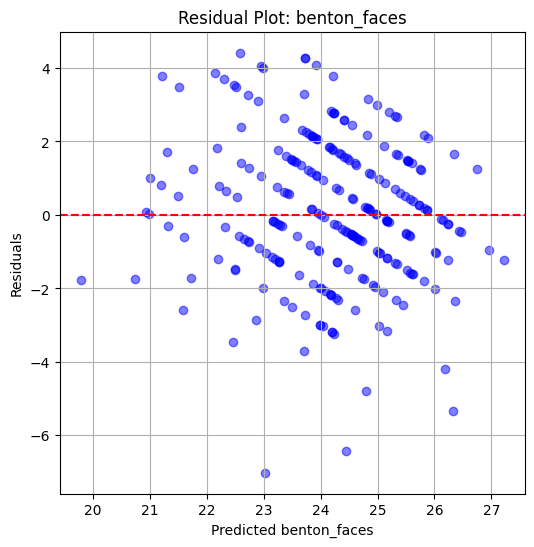

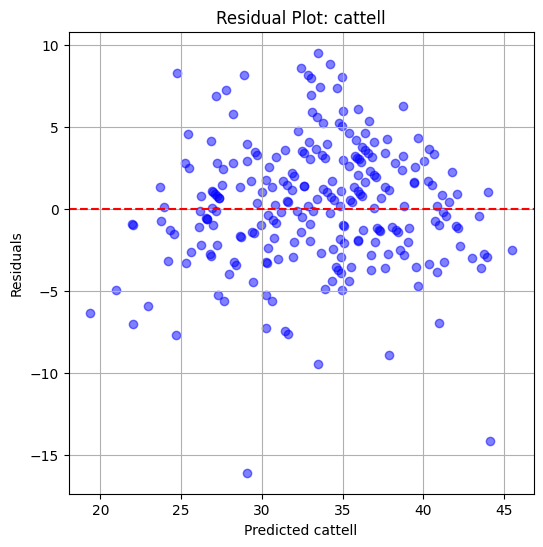

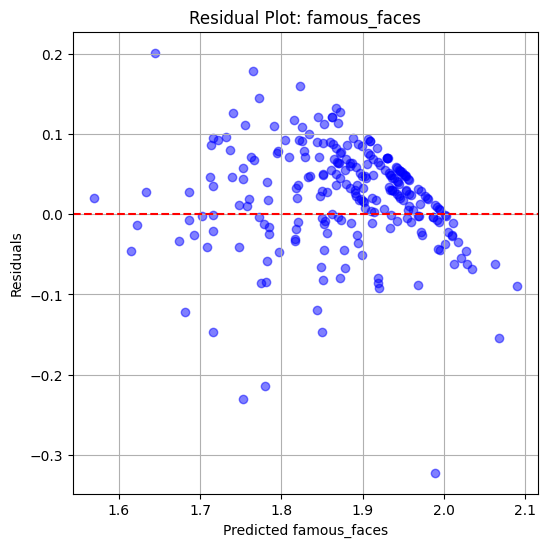

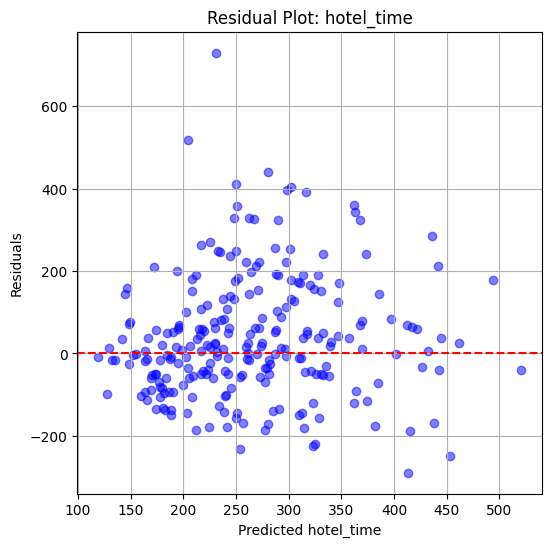

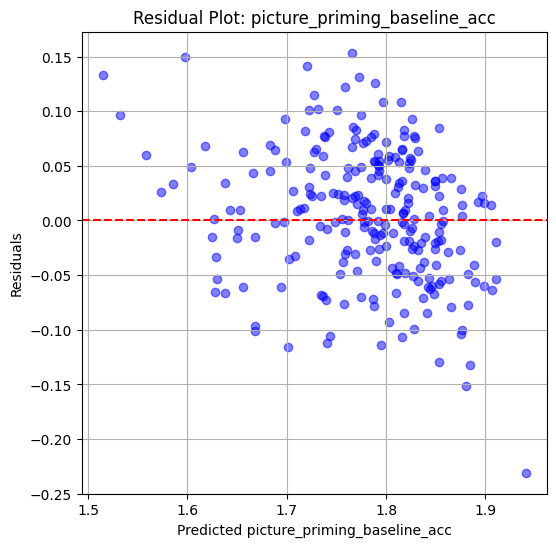

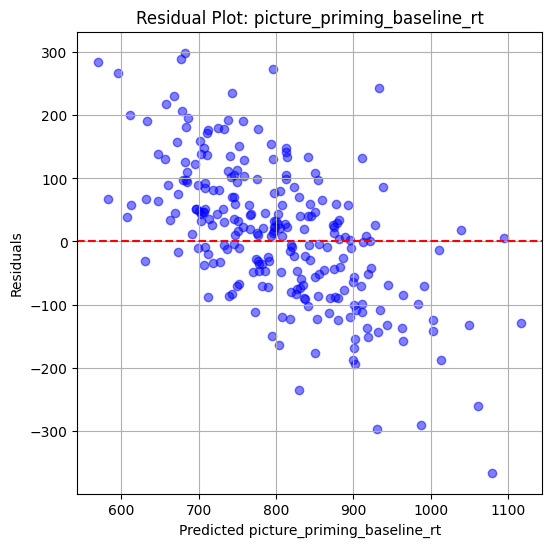

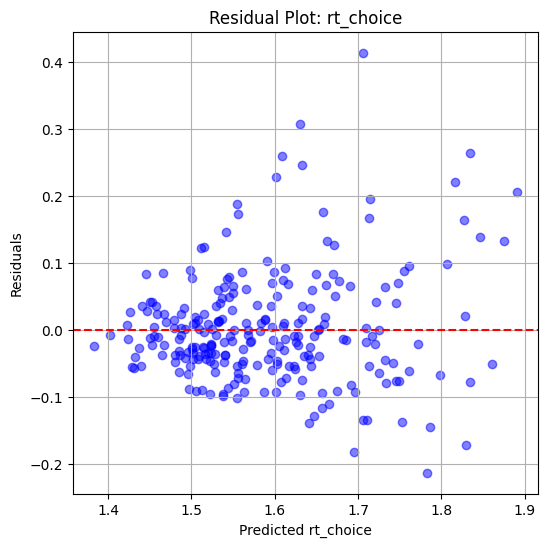

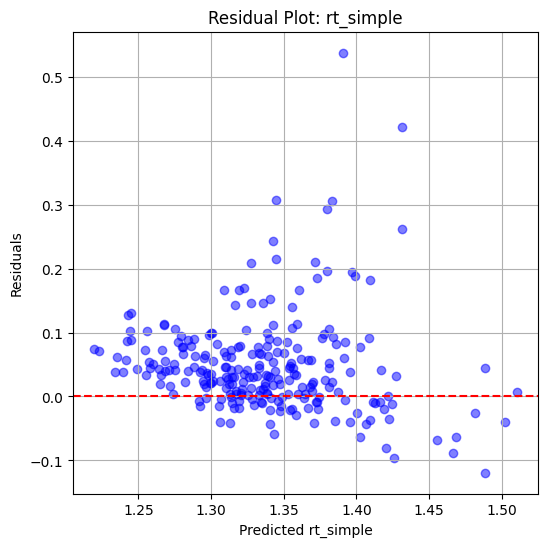

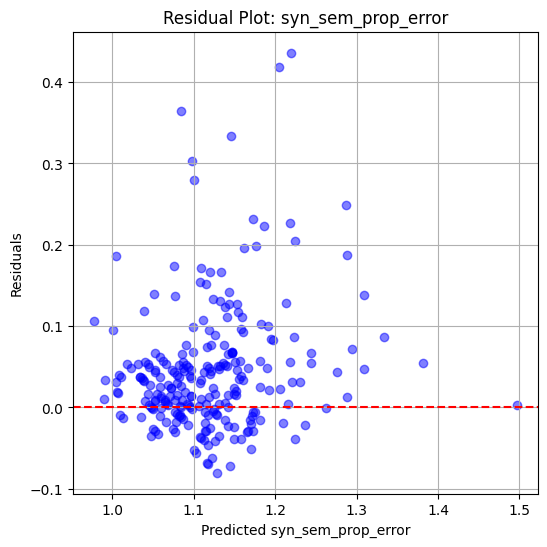

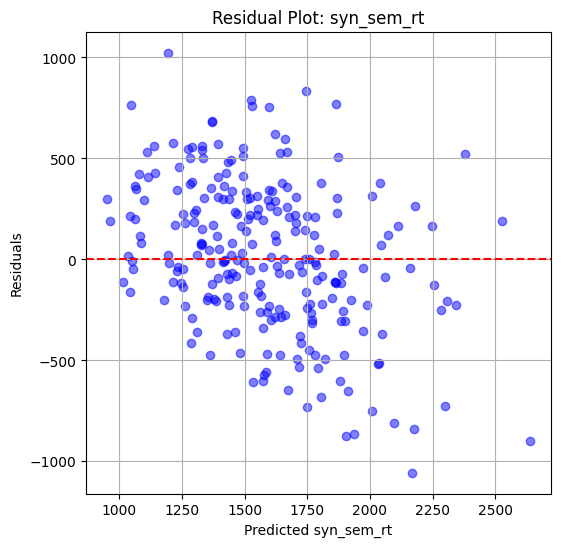

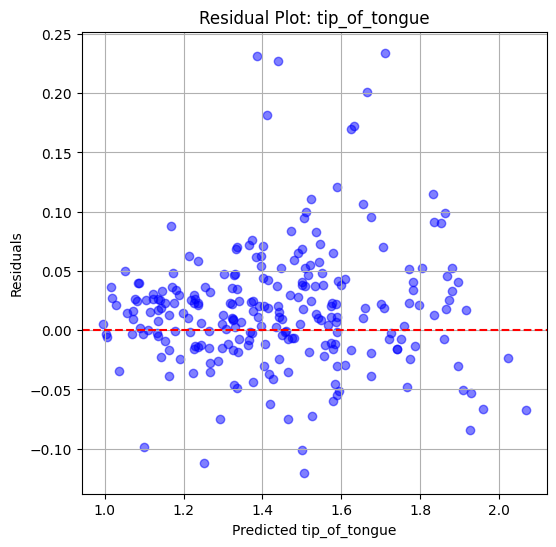

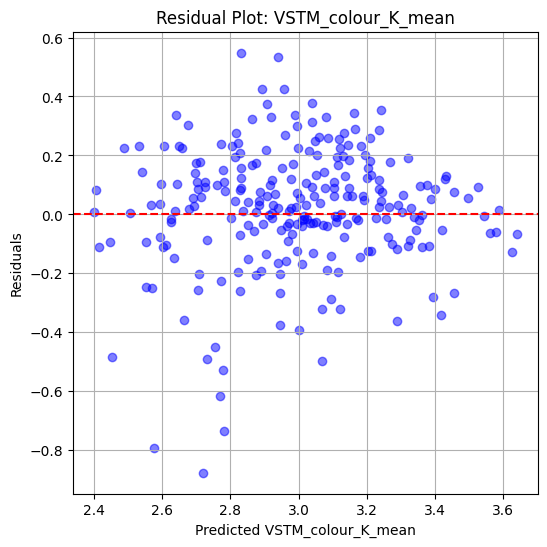

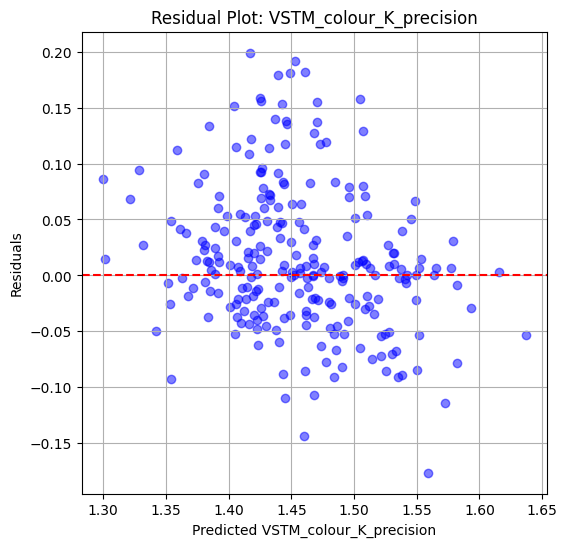

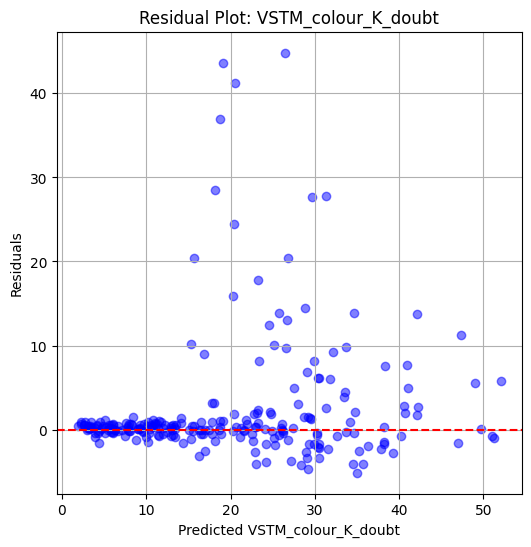

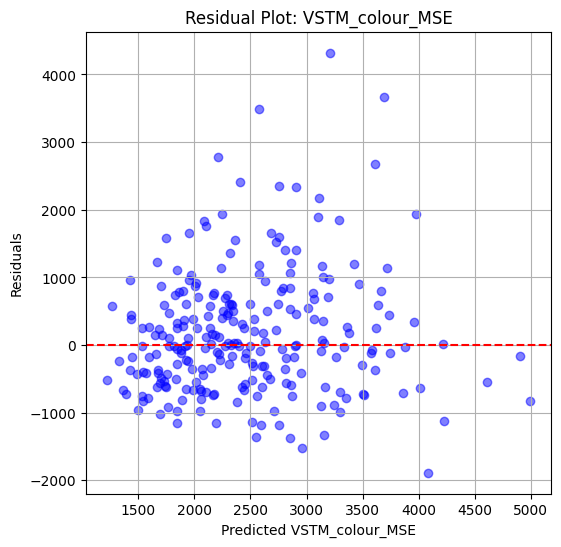

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
y_train_pred = X_train  # Assuming the model predictions are stored in the same format as X_train

# Calculate residuals
residuals_train = y_train - y_train_pred  # True values - predicted values

# Plot residuals for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_pred[:, i], residuals_train[:, i], alpha=0.5, color='b')
    plt.axhline(0, color='red', linestyle='--')  # Horizontal line at y=0 (zero residuals)
    plt.title(f'Residual Plot: {target}')
    plt.xlabel(f'Predicted {target}')
    plt.ylabel(f'Residuals')
    plt.grid(True)
    plt.show()


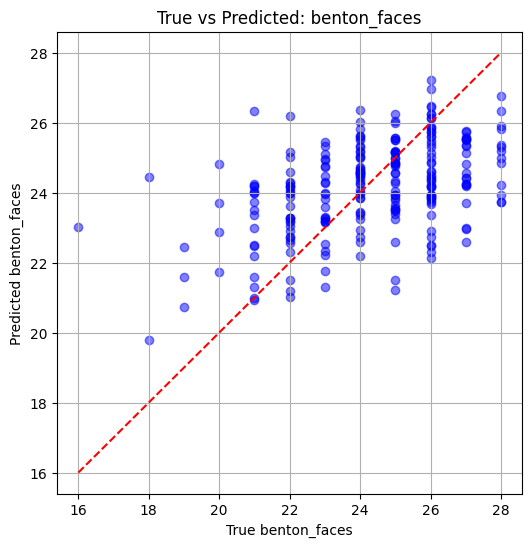

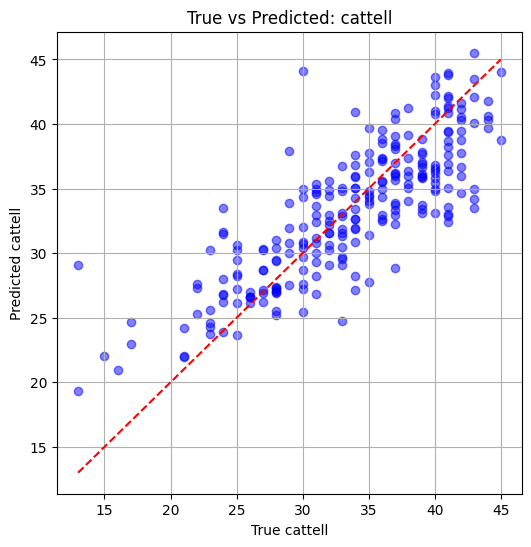

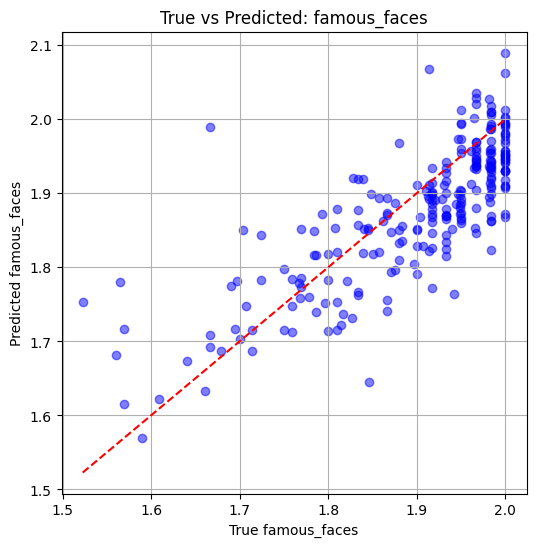

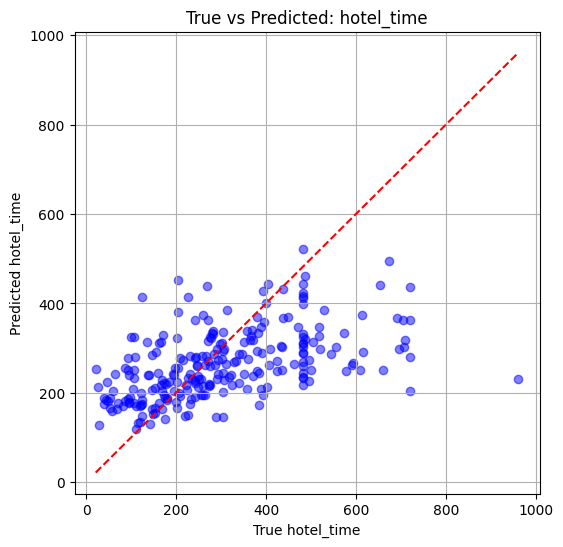

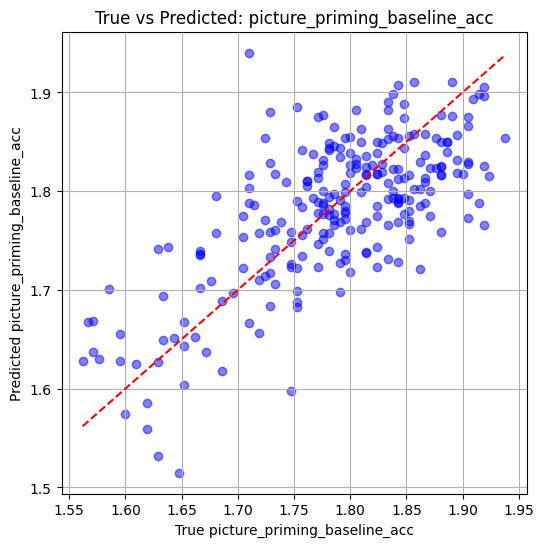

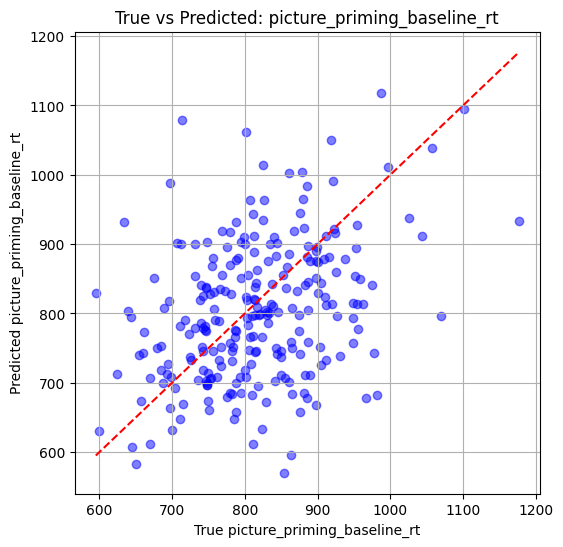

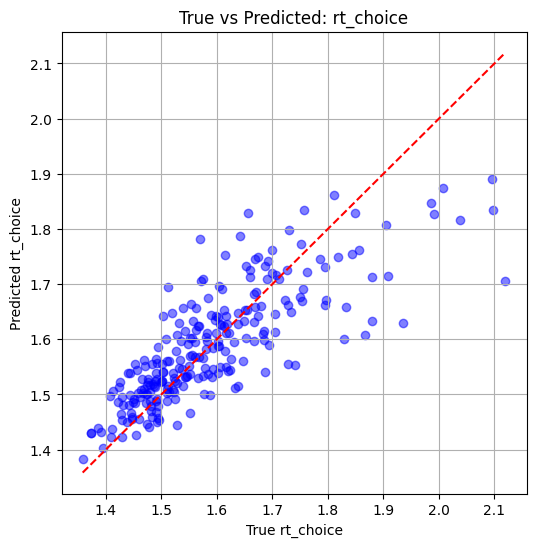

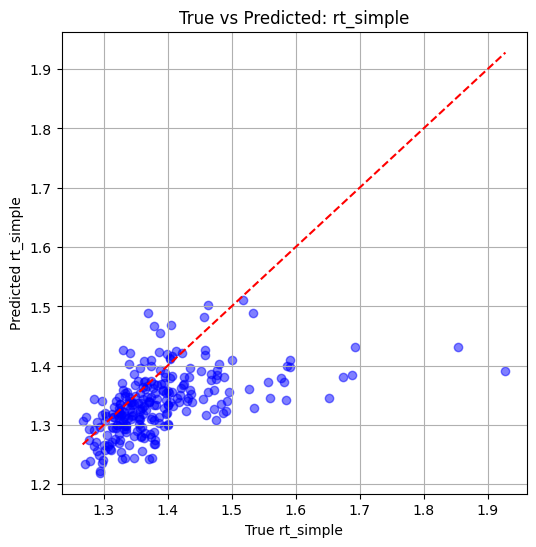

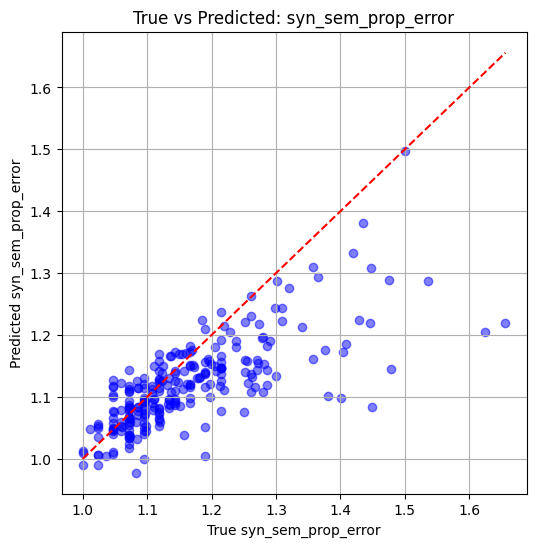

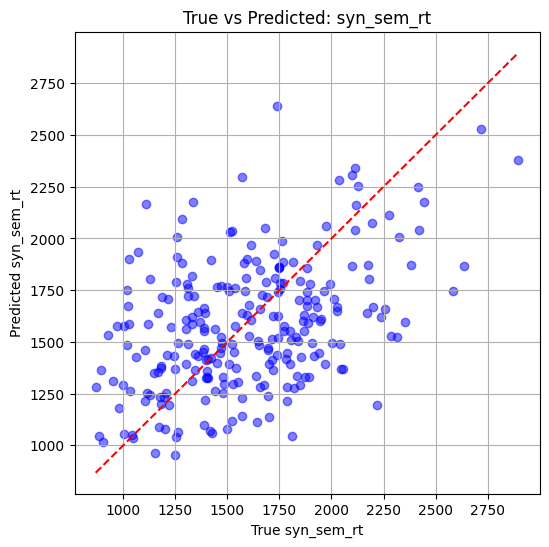

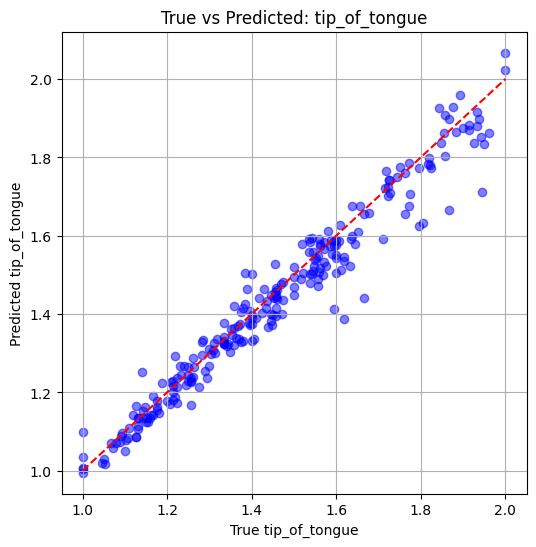

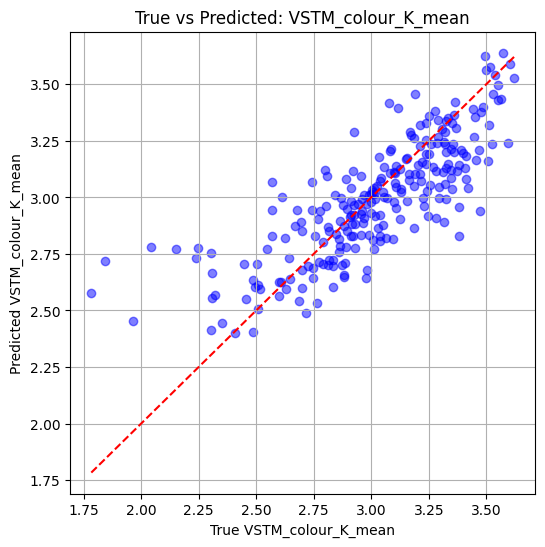

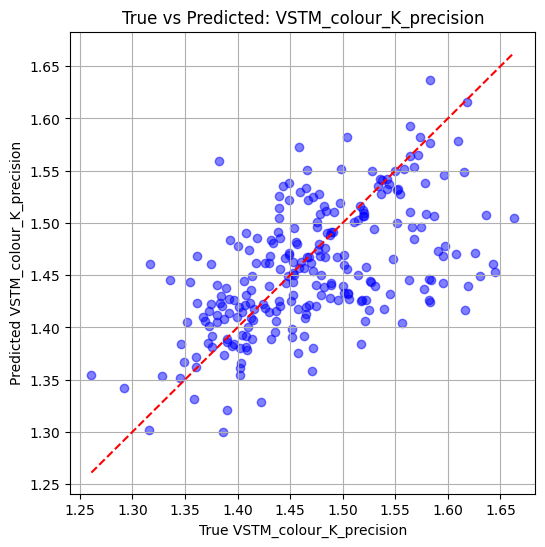

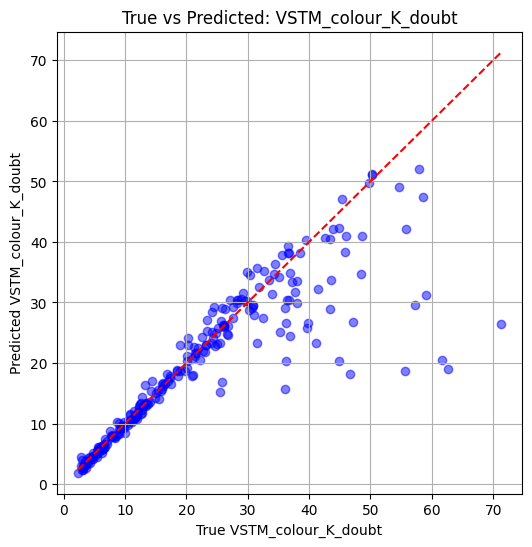

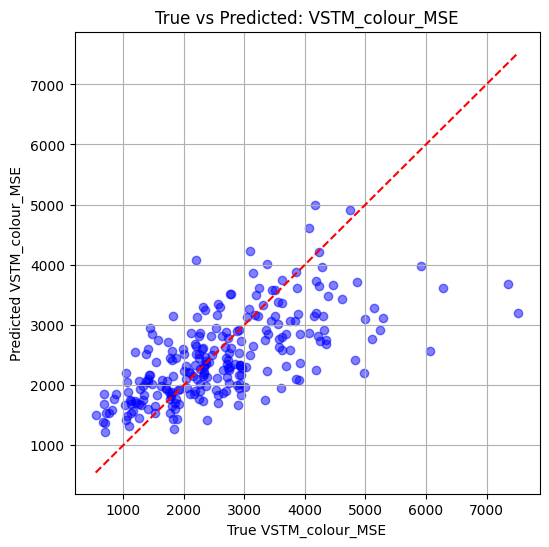

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values

# Plot true vs predicted values for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train[:, i], X_train[:, i], alpha=0.5, color='b')
    plt.plot([y_train[:, i].min(), y_train[:, i].max()], [y_train[:, i].min(), y_train[:, i].max()], color='red', linestyle='--')  # Line for perfect predictions
    plt.title(f'True vs Predicted: {target}')
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.grid(True)
    plt.show()
